In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

In [24]:
class ResourceAllocatingNetwork:
    def __init__(self, input_size, output_size):
        self.input_size = input_size
        self.output_size = output_size
        self.centers = []
        self.widths = []
        self.weights = []
        self.gamma = np.zeros(output_size)

    def gradient_descent(self, input_vector, x, error, alpha):

        # updating the value of gamma according to this formula: gamma = gamma + alpha * error
        self.gamma  += alpha * error

        # updating the values of weights and centers
        DiffInWidths = []
        for j in range(len(self.centers)):
            # Because the index of list starts from zero but j starts from 1, the indexes of variables are j-1
            # updating weight(h) according to : h = h + alpha * error * x
            # x is a list that keeps the distance of current input data from every center in the list of centers.
            xj = x[j-1]
            er_mul_xj = np.zeros(len(error))
            for i in range(len(error)):
                er_mul_xj[i-1] = alpha * xj * error[i-1] # alpha and xj are scalr but error has a dimension of output_size=3
            weight = self.weights[j-1] # weight and weight1 are a temporary variable to calculate weights and have dimension of output_size=3
            # weight and er_mul_xj has a dimension of output=3
            self.weights[j-1] = weight + er_mul_xj

            # Updating center according to : c = c + (2 * alpha / width) * (Input - c) * x * (error * h)
            Mul_2Alphal_DivWid_Xj = 2 * (alpha / self.widths[j-1]) * xj
            # Calculating "vector multiplication" of "error and weight(h)"
            # weight and error has a dimension of output=3
            er_mul_weight = 0
            for i in range(len(error)):
                er_mul_weight += error[i - 1] * weight[i - 1]
            Mul_2Alphal_XjDivWid_Er_Weight = Mul_2Alphal_DivWid_Xj * er_mul_weight
            center = self.centers[j-1]  # center is a temporary variable to calculate centers and has a dimension of input_size
            # Calculating "Input - c"
            InpMinuesCent = np.zeros(len(center))
            for i in range(len(center)):
                InpMinuesCent[i-1] = input_vector[i-1] - center[i-1]
            # Updating center
            DeltaCenter = np.zeros(len(center))
            for i in range(len(center)):
                DeltaCenter[i-1] = InpMinuesCent[i-1] * Mul_2Alphal_XjDivWid_Er_Weight
            self.centers[j-1] = self.centers[j-1] + DeltaCenter

            # Gradient descent for updating widths
            Mul_2Alphal_DivWidPow3_Xj = 2 * (alpha / (self.widths[j-1])**3) * xj
            Mul_2Alphal_DivWidPow3_Xj_Er_Weight = Mul_2Alphal_DivWidPow3_Xj * er_mul_weight
            Zj= 0
            for i in range(len(center)):
                Zj = Zj + ((center[i - 1] -input_vector[i - 1]) ** 2)
            DeltaWidth =  Mul_2Alphal_DivWidPow3_Xj_Er_Weight * Zj
            DiffInWidths.append(DeltaWidth)
            self.widths[j-1] = self.widths[j-1] + DeltaWidth


        #print('Centers in this Gradient Descent are changed as follows: ')
        #print(self.centers)
        #print('Weights in this Gradient Descent are changed as follows: ')
        #print(self.weights)
        #print('Difference between previous widths and new width in this Gradient Descent are changed as follows: ')
        #print(DiffInWidths)
        # print('Widths in this Gradient Descent are changed as follows: ')
        #print(self.widths)
        #print('gamma in this Gradient Descent are changed as follows: ')
        ##print(self.gamma)

    def train(self, input_vectors, target_outputs, epsilon, delta_max, delta_min, k, tau, alpha, num_epochs, error_threshold):
        # The distance "delta" is the scale of resolution that the network is fitting at the ith input presentation.
        # The learning starts with delta = delta_max
        delta = delta_max
        # gamma is the default output of the network when none of the first-layer units are active.
        # At the first step of training, the value of gamma is the first output(Y).
        self.gamma = target_outputs[0]
        # At the first step of training, the value of the first center is the first input data(X)
        self.centers.append(input_vectors[0])
        width = k * delta # The value of the width of the first center is k * delta
        self.widths.append(width)
        # The value of the weight (h in the article) for the first center is selected randomly
        # The dimension of the weight is equal to the dimension of Y (output)
        weight = np.zeros(output_size)
        for i in range(len(weight)):
            weight [i-1] = np.random.uniform(-1, 1)
        self.weights.append(weight)
        epoch_mse_errors = []  # keeping the amount of error value in every epoch
        numbers_of_centers = []
        GradStep_PerEpoch=[]
        l_NewC = []
        epoch = 1
        while epoch <= num_epochs:
        #for epoch in range(num_epochs):

            epoch_mse_error = 0  # Accumulate the error for each epoch
            input_number = len(input_vectors) # Obtaining the amount of input data
            Delta_Ins_NewC = []
            Ins_NewC = 0
            GradStep_BefIns = 0
            L_GradStep_BefIns = []

            for i in range(input_number):
                # The index of list starts from zero but index 0 is used before "for loop" as the first items and default values
                # Then from the second item in input_vector which has index of 1 will be considered
                input_vector = input_vectors[i]
                target_output = target_outputs[i]
                # Calculating x according to the Gaussian Formula: zj = sigma (cjk - Ik ) ** 2 and xj = exp ( - zj / widthj ** 2)
                # Because x is a list that keeps the distance of current input data from every center in the list of centers.
                # Then, for every center in the list of centers, x should be calculated
                x = np.zeros(len(self.centers))
                for j in range(len(self.centers)):
                    x[j-1] = np.exp((-1 * np.sum((self.centers[j-1] - input_vector) ** 2))/ (self.widths[j-1] ** 2))
                # Calculating output according to the x, weight (h in the formula) and gamma
                # The formula is: y(output) = sigma(hj(weight)*xj) + gamma
                hx = np.zeros(len(target_output))
                for j in range(len(self.centers)):
                    # Because the index of list starts from zero but j starts from 1, the indexes of variables are j-1
                    xj = x[j-1]
                    hj = self.weights[j-1]
                    hj = hj * xj
                    hx += hj
                output = hx + self.gamma
                error = target_output - output # Calculating error for current input
                # Calculating minimum distance of current input from every center in the list of centers
                d1 = np.zeros(len(self.centers))
                # np.linalg.norm calculates the Euclidean norm of the vector
                for j in range(len(self.centers)):
                    d1[j-1] = np.linalg.norm(self.centers[j-1] - input_vector)
                distance = np.min(d1)
                # Evaluating the condition of creating new center, weight and width
                if (np.linalg.norm(error) > epsilon) and (distance > delta):
                   #print ("The condition that insert new center is TRUE and ")
                   Ins_NewC = Ins_NewC + 1
                   Delta_Ins_NewC.append(delta)
                   #print("The Number of Gradient Step Before Insertion is " + str(GradStep_BefIns))
                   L_GradStep_BefIns.append(GradStep_BefIns)
                   # Creating new center
                   center = input_vector
                   self.centers.append(center)
                   # Creating new weight according to creaed center
                   weight = error
                   self.weights.append(weight)
                   # Creating new width according to creaed center
                   width = k * distance
                   self.widths.append(width)
                else:
                   GradStep_BefIns = GradStep_BefIns + 1

                   # if the condition of creating new center was not true, the gradient descent method should be run
                   self.gradient_descent(input_vector, x, error, alpha)

                if delta > delta_min:
                   delta = delta * np.exp(-1 / tau)
                # Converting error vector to a scaler number in oder to giving it to the plot
                mse_error = np.sqrt(np.sum(error ** 2))
                epoch_mse_error += mse_error  # Accumulate the squared error
            epoch_mse_error /= len(input_vectors)  # Calculate the MSE for the epoch
            epoch_mse_errors.append(epoch_mse_error)
            print('The amount of error in ' + f'Epoch {epoch}' + ' is: ' + str(epoch_mse_error))
            l_NewC.append(Ins_NewC)
            print('The Number of New Centers in ' + f'Epoch {epoch}' + ' is: ' + str(Ins_NewC))
            print('The Number of going through Gradient Descent in ' + f'Epoch {epoch}' + ' is: ' + str(GradStep_BefIns))
            GradStep_PerEpoch.append(GradStep_BefIns)
            numbers_of_centers.append(len(self.centers))
            print('The number of centers in '+ f'Epoch {epoch}' + ' is: ' + str(len(self.centers)))
            print('The Centers in '+ f'Epoch {epoch}' + ' are as follows: ')
            print(self.centers)
            centers_matrix = np.array(self.centers)
            # Print Scatter Plot of centers and Input Data
            plt.scatter(input_vectors[:, 2], input_vectors[:, 3], label='Input Data', marker='o', edgecolors='blue', facecolors='none')
            plt.scatter(centers_matrix[:, 2], centers_matrix[:, 3], marker='X', color='red', label='Centers')
            plt.xlabel('Feature 3')
            plt.ylabel('Feature 4')
            plt.title(f'Epoch {epoch}')
            plt.legend()
            plt.show()
            #Print the amount of Delta in Insertion New Centers in this epoch
            #print("The amount of Delta in Insertion New Centers in " + f'Epoch {epoch + 1}' + " is: ")
            #print(Delta_Ins_NewC)
            # Break the loop if the error is less than 0.2
            if epoch_mse_error < error_threshold:
                break

            if epoch < (num_epochs + 1):
                epoch += 1

        #Plot the errors
        # Normalize GradStep_PerEpoch
        # Define the desired range for normalization
        if epoch == (num_epochs + 1):
            epoch = epoch - 1
        max_mse_error = max(epoch_mse_errors)
        min_mse_error = min(epoch_mse_errors)
        # Find the min and max values of GradStep_PerEpoch
        min_gradstep_value = min(GradStep_PerEpoch)
        max_gradstep_value = max(GradStep_PerEpoch)
        # Normalize the values to the desired range
        RangeOfGradStep = max_gradstep_value - min_gradstep_value
        rangeOfMse = max_mse_error - min_mse_error
        normalized_gradstep = [min_mse_error + ((value - min_gradstep_value) / (RangeOfGradStep)) * (rangeOfMse) for value in GradStep_PerEpoch]

        plt.plot(range(epoch), epoch_mse_errors, label='MSE Errors')
        plt.plot(range(epoch), normalized_gradstep, label='Normalized GradStep')
        plt.xlabel('Epoch')
        plt.ylabel('value')
        plt.title('MSE and Normalized Numbers of Gradient step in everyepoch vs Epoch')
        plt.legend()
        plt.show()

        plt.plot(range(epoch), numbers_of_centers, label='Number of Centers in every epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Number of Centers')
        plt.title('Number of Centers in every epoch vs Epoch')
        plt.legend()
        plt.show()

        print("The Number of going through Gradient Descent in all epochs are: ")
        print(GradStep_PerEpoch)
        print("The Number of New Centers in all epochs are: ")
        print(l_NewC)
        print("The number of centers are: " + str(len(self.centers)))
        print("The Centers at the end of algorithm are as follows: ")
        print(self.centers)
        print("The amount of errors are as follows: ")
        print(epoch_mse_errors)

    def predict(self, input_vectors):
        output_vector = []
        for i in range(len(input_vectors)):
            input_vector = input_vectors[i]
            # Calculating x according to the Gaussian Formula: zj = sigma (cjk - Ik ) ** 2 and xj = exp ( - zj / widthj ** 2)
            # Because x is a list that keeps the distance of current input data from every center in the list of centers.
            # Then, for every center in the list of centers, x should be calculated
            x = np.zeros(len(self.centers))
            for j in range(len(self.centers)):
                x[j - 1] = np.exp((-1 * np.sum((self.centers[j - 1] - input_vector) ** 2)) / (self.widths[j - 1] ** 2))
            # Calculating output according to the x, weight (h in the formula) and gamma
            # The formula is: y(output) = sigma(hj(weight)*xj) + gamma
            hx = np.zeros(self.output_size)
            for j in range(len(self.centers)):
                xj = x[j - 1]
                hj = self.weights[j - 1]
                hj = hj * xj
                hx += hj
            output = hx + self.gamma
            output_vector.append(output)
        return np.argmax(output_vector, axis=1)

In [25]:
# Usage with Iris dataset
iris = load_iris()
X = iris.data
y = iris.target
# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)
#Split Iris datast to train and test sections
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# One-hot encode the target outputs:
# OneHotEncoder is used for converting categorical integer features (like class labels) into a one-hot encoded representation.
# For example in Iris dataset we have 3 categorical data then (0, 1, 0) shows category No. 2
encoder = OneHotEncoder()
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1)).toarray()

In [26]:
# Create and train the RAN
input_size = X_train.shape[1]
#input_size which is shape[1] of Iris dataset is the number of columns(feaures) in Iris dataset that is 2
output_size = y_train_encoded.shape[1]
#output_size which is shape[1] of one-hot encoded is the number of columns(class labels) in Iris dataset that is 3

Enter the learning rate (alpha): 0.02
Enter the Error Threshold (error_threshold): 0.2
The amount of error in Epoch 1 is: 0.5214874937321661
The Number of New Centers in Epoch 1 is: 16
The Number of going through Gradient Descent in Epoch 1 is: 104
The number of centers in Epoch 1 is: 17
The Centers in Epoch 1 are as follows: 
[array([-1.657302  ,  1.31472969, -1.64850121, -1.32822449]), array([0.97303246, 0.06481768, 0.35758883, 0.26373107]), array([-0.43251327, -1.509883  , -0.03115981, -0.24407835]), array([1.64712797, 1.22226853, 1.33514904, 1.69315491]), array([ 2.22801428, -0.57427069,  1.65699578,  1.05699125]), array([-1.49615005,  0.33307497, -1.34079413, -1.31491189]), array([-0.18109473, -1.29136256,  0.71846856,  1.0730772 ]), array([ 0.20495133, -0.12903435,  0.62143518,  0.84681295]), array([0.44083065, 0.77890178, 0.93883411, 1.45328413]), array([ 0.67999652, -0.81459086,  0.88408362,  0.93049446]), array([-0.0526234 , -0.59232233,  0.76273409,  1.58033094]), array([-1.0

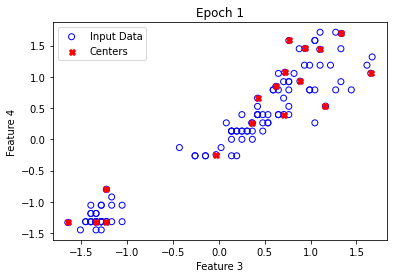

The amount of error in Epoch 2 is: 0.2662193489764485
The Number of New Centers in Epoch 2 is: 4
The Number of going through Gradient Descent in Epoch 2 is: 116
The number of centers in Epoch 2 is: 21
The Centers in Epoch 2 are as follows: 
[array([-1.66790851,  1.30412808, -1.65195525, -1.32883933]), array([0.95330791, 0.05371792, 0.36256975, 0.27551154]), array([-0.43343887, -1.50778077, -0.03200805, -0.23822413]), array([1.65717173, 1.22376183, 1.34225037, 1.69804434]), array([ 2.23736868, -0.56712604,  1.66050352,  1.06489332]), array([-1.4945517 ,  0.3416008 , -1.34043202, -1.31538841]), array([-0.21504729, -1.35230577,  0.73408744,  1.11828207]), array([ 0.18806738, -0.09182642,  0.65657133,  0.92603942]), array([0.4397669 , 0.78276972, 0.94340332, 1.45901239]), array([ 0.69825355, -0.82521603,  0.91039993,  0.95789139]), array([-0.05277471, -0.59135281,  0.76288274,  1.58366003]), array([-1.01969357,  1.01797617, -1.22932877, -0.80475865]), array([1.27780709, 0.31482232, 1.10218

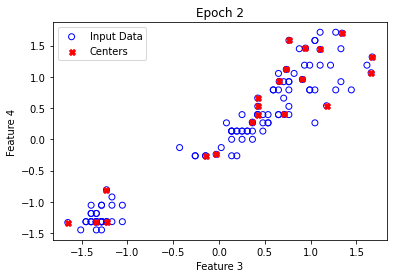

The amount of error in Epoch 3 is: 0.24688696398330173
The Number of New Centers in Epoch 3 is: 0
The Number of going through Gradient Descent in Epoch 3 is: 120
The number of centers in Epoch 3 is: 21
The Centers in Epoch 3 are as follows: 
[array([-1.64145294,  1.27627868, -1.6354363 , -1.32555248]), array([0.96649347, 0.05382616, 0.37886215, 0.30190764]), array([-0.43338542, -1.51922883, -0.03669737, -0.23949717]), array([1.67725881, 1.23957349, 1.35398529, 1.70742036]), array([ 2.25981804, -0.56591239,  1.6723772 ,  1.07322642]), array([-1.50108136,  0.3434281 , -1.34149772, -1.31691919]), array([-0.25680156, -1.41468347,  0.74797689,  1.16147463]), array([ 0.14352751, -0.05882   ,  0.67473405,  0.97506442]), array([0.43176871, 0.79339221, 0.94621628, 1.46495552]), array([ 0.71524482, -0.84740017,  0.94245999,  0.98739624]), array([-0.05298518, -0.58990791,  0.76294591,  1.58737788]), array([-1.02060798,  1.01807583, -1.2285834 , -0.79555995]), array([1.28478867, 0.31698308, 1.1063

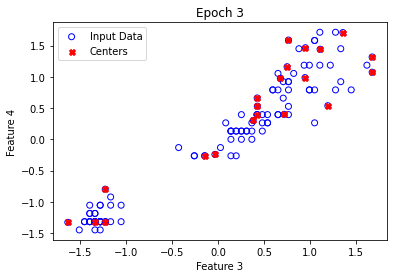

The amount of error in Epoch 4 is: 0.24617647949577307
The Number of New Centers in Epoch 4 is: 0
The Number of going through Gradient Descent in Epoch 4 is: 120
The number of centers in Epoch 4 is: 21
The Centers in Epoch 4 are as follows: 
[array([-1.6046575 ,  1.24654146, -1.6138977 , -1.32111683]), array([0.99609967, 0.06014509, 0.39818554, 0.33162182]), array([-0.43190461, -1.53470866, -0.04291962, -0.24408878]), array([1.69932628, 1.26240512, 1.36664   , 1.71900229]), array([ 2.28653063, -0.57028009,  1.68782711,  1.08011737]), array([-1.51030164,  0.34214065, -1.34336207, -1.3188636 ]), array([-0.29230045, -1.46340126,  0.7611454 ,  1.19781612]), array([ 0.09504173, -0.03973606,  0.68441384,  1.00195822]), array([0.4193385 , 0.80671808, 0.94800993, 1.47057435]), array([ 0.72190377, -0.8730058 ,  0.97053154,  1.00996664]), array([-0.05309868, -0.58834769,  0.76285982,  1.58957159]), array([-1.02262362,  1.01885885, -1.22749828, -0.78053139]), array([1.29282087, 0.3208728 , 1.1116

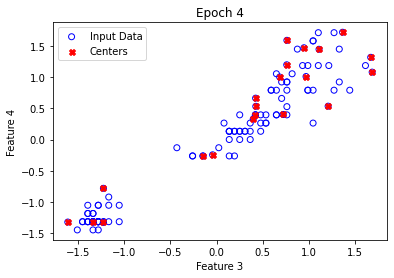

The amount of error in Epoch 5 is: 0.23798503805221555
The Number of New Centers in Epoch 5 is: 1
The Number of going through Gradient Descent in Epoch 5 is: 119
The number of centers in Epoch 5 is: 22
The Centers in Epoch 5 are as follows: 
[array([-1.56933352,  1.22097901, -1.59359266, -1.31652311]), array([1.03253021, 0.05954294, 0.41986389, 0.3558252 ]), array([-0.42535554, -1.55179024, -0.04500025, -0.24856641]), array([1.71837441, 1.28487477, 1.37782863, 1.7298498 ]), array([ 2.31172478, -0.5761817 ,  1.70264973,  1.08538306]), array([-1.51866966,  0.34032206, -1.3453987 , -1.32071674]), array([-0.32404278, -1.49884745,  0.77089403,  1.2332702 ]), array([ 0.05086814, -0.02425201,  0.68712297,  1.01790276]), array([0.40546221, 0.81884045, 0.94954504, 1.47533014]), array([ 0.72379904, -0.89120415,  0.99155641,  1.03212915]), array([-0.05303325, -0.58662492,  0.76260638,  1.58970148]), array([-1.02518852,  1.01926083, -1.2268595 , -0.76620611]), array([1.29970666, 0.32461896, 1.1170

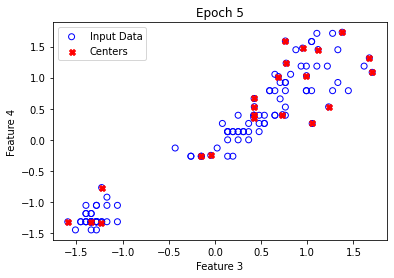

The amount of error in Epoch 6 is: 0.22678296146750226
The Number of New Centers in Epoch 6 is: 0
The Number of going through Gradient Descent in Epoch 6 is: 120
The number of centers in Epoch 6 is: 22
The Centers in Epoch 6 are as follows: 
[array([-1.53967828,  1.20161547, -1.5767629 , -1.31222981]), array([1.07135088, 0.05295353, 0.438829  , 0.37512183]), array([-0.4142755 , -1.56899686, -0.04454783, -0.25155421]), array([1.73409721, 1.30546084, 1.38743672, 1.73945977]), array([ 2.33441204, -0.58233961,  1.71637781,  1.0891407 ]), array([-1.52488402,  0.33897243, -1.34726816, -1.32227438]), array([-0.35327051, -1.52581941,  0.78009932,  1.2665663 ]), array([ 0.01054029, -0.0092381 ,  0.68711501,  1.02772633]), array([0.39093162, 0.82921156, 0.95084855, 1.47899869]), array([ 0.7226995 , -0.90406412,  1.0098959 ,  1.05243373]), array([-0.05282   , -0.58448233,  0.76223349,  1.58849204]), array([-1.02783692,  1.01887091, -1.22677808, -0.75504743]), array([1.30530687, 0.32791987, 1.1226

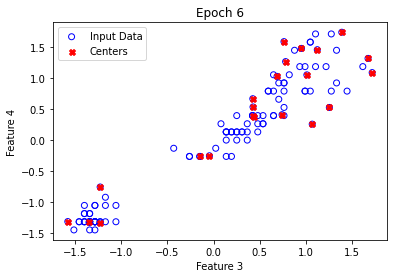

The amount of error in Epoch 7 is: 0.22277026275447637
The Number of New Centers in Epoch 7 is: 0
The Number of going through Gradient Descent in Epoch 7 is: 120
The number of centers in Epoch 7 is: 22
The Centers in Epoch 7 are as follows: 
[array([-1.51507609,  1.18733677, -1.56303298, -1.30830703]), array([1.10898031, 0.04045425, 0.45374239, 0.38956844]), array([-0.39893821, -1.58528735, -0.04168694, -0.25258971]), array([1.74677617, 1.32346872, 1.39562515, 1.74766348]), array([ 2.35461633, -0.58783999,  1.72892459,  1.09175532]), array([-1.52919837,  0.33812473, -1.34890659, -1.32355293]), array([-0.38078464, -1.54726691,  0.78944424,  1.29823349]), array([-0.02594754,  0.00633007,  0.68643249,  1.03463467]), array([0.37628031, 0.8380609 , 0.95200459, 1.48173399]), array([ 0.72007374, -0.91239969,  1.02673969,  1.07090912]), array([-0.05243184, -0.58165602,  0.76179177,  1.58673932]), array([-1.03036572,  1.01782062, -1.22708579, -0.74673989]), array([1.3099285 , 0.33082693, 1.1283

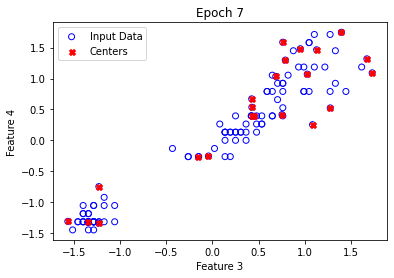

The amount of error in Epoch 8 is: 0.2202110236952998
The Number of New Centers in Epoch 8 is: 0
The Number of going through Gradient Descent in Epoch 8 is: 120
The number of centers in Epoch 8 is: 22
The Centers in Epoch 8 are as follows: 
[array([-1.49411441,  1.17658094, -1.55160767, -1.30476627]), array([1.14363584, 0.02420447, 0.46423677, 0.39977288]), array([-0.38035688, -1.60003512, -0.03685894, -0.25176424]), array([1.75691208, 1.33892827, 1.40267801, 1.75463446]), array([ 2.37263513, -0.59248011,  1.74043703,  1.09354156]), array([-1.53213492,  0.33758426, -1.35034592, -1.32461594]), array([-0.40615533, -1.56528062,  0.79912013,  1.32799979]), array([-0.05841728,  0.02190246,  0.68609406,  1.04023434]), array([0.36186475, 0.84607896, 0.95318564, 1.4839478 ]), array([ 0.71691359, -0.91772669,  1.04243935,  1.08738439]), array([-0.05185322, -0.57804231,  0.76133449,  1.5849944 ]), array([-1.03271379,  1.0163407 , -1.22763347, -0.74049571]), array([1.31385067, 0.33349596, 1.13422

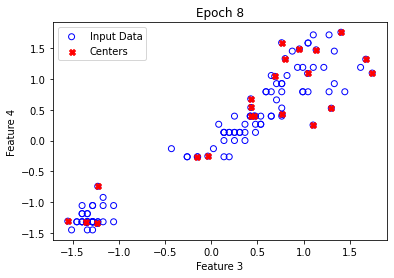

The amount of error in Epoch 9 is: 0.21851561082738352
The Number of New Centers in Epoch 9 is: 0
The Number of going through Gradient Descent in Epoch 9 is: 120
The number of centers in Epoch 9 is: 22
The Centers in Epoch 9 are as follows: 
[array([-1.47580216,  1.16817088, -1.54192576, -1.30162599]), array([1.17506725, 0.00692644, 0.47068061, 0.40687029]), array([-0.3598471 , -1.61306222, -0.03073148, -0.24945231]), array([1.76514912, 1.35245166, 1.40895042, 1.76080649]), array([ 2.38900468, -0.59659031,  1.75126257,  1.09469992]), array([-1.53407238,  0.33719903, -1.35162273, -1.32551364]), array([-0.42875541, -1.58108388,  0.80903438,  1.35512088]), array([-0.08700092,  0.0363933 ,  0.68645003,  1.04497555]), array([0.34777251, 0.85407599, 0.9545732 , 1.48610186]), array([ 0.71351424, -0.92148055,  1.05694089,  1.10153505]), array([-0.05111043, -0.57369031,  0.76092169,  1.58362543]), array([-1.03486419,  1.01460665, -1.22833064, -0.7357354 ]), array([1.31724821, 0.33604506, 1.1403

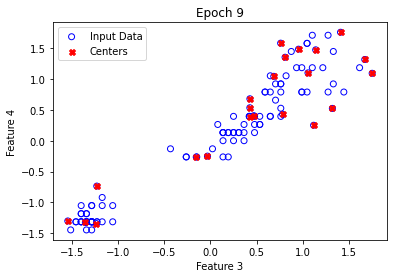

The amount of error in Epoch 10 is: 0.21736740514056058
The Number of New Centers in Epoch 10 is: 1
The Number of going through Gradient Descent in Epoch 10 is: 119
The number of centers in Epoch 10 is: 23
The Centers in Epoch 10 are as follows: 
[array([-1.45879796,  1.16438686, -1.53347084, -1.29888868]), array([ 1.20252178, -0.01060511,  0.47214347,  0.41077112]), array([-0.34150126, -1.62530563, -0.02690876, -0.24815927]), array([1.77181379, 1.36422374, 1.41460267, 1.76634383]), array([ 2.40362629, -0.60033614,  1.76133652,  1.09513911]), array([-1.53528162,  0.33680935, -1.35276923, -1.32627954]), array([-0.44782237, -1.59484716,  0.81914215,  1.37890408]), array([-0.11135453,  0.04901607,  0.68760462,  1.0486258 ]), array([0.33431195, 0.86220543, 0.95628701, 1.48827288]), array([ 0.7100349 , -0.92411939,  1.06998014,  1.11293349]), array([-0.05029361, -0.56871771,  0.76061671,  1.582829  ]), array([-1.03683231,  1.01271469, -1.22912085, -0.73203154]), array([1.32008087, 0.3383774

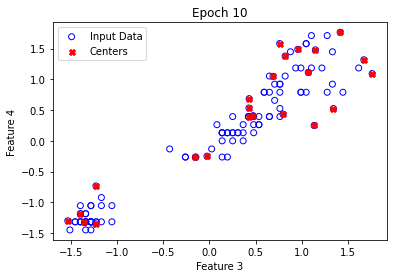

The amount of error in Epoch 11 is: 0.2119957682404672
The Number of New Centers in Epoch 11 is: 0
The Number of going through Gradient Descent in Epoch 11 is: 120
The number of centers in Epoch 11 is: 23
The Centers in Epoch 11 are as follows: 
[array([-1.4424223 ,  1.16208844, -1.52578384, -1.29642838]), array([ 1.22779329, -0.02710462,  0.47163602,  0.41430126]), array([-0.32355681, -1.63613574, -0.02292016, -0.24598415]), array([1.77765246, 1.37523992, 1.41998548, 1.77171522]), array([ 2.4175045 , -0.6042256 ,  1.77122597,  1.09505464]), array([-1.53601949,  0.33622259, -1.35380928, -1.32695478]), array([-0.46402034, -1.60781223,  0.82915277,  1.3993821 ]), array([-0.13253526,  0.0599437 ,  0.68925347,  1.05140549]), array([0.32121904, 0.87124679, 0.95837388, 1.49081398]), array([ 0.70659776, -0.92659712,  1.08179484,  1.12207023]), array([-0.04962715, -0.56336892,  0.76048745,  1.58298311]), array([-1.03858788,  1.01082174, -1.2299603 , -0.72906863]), array([1.32252467, 0.34062203

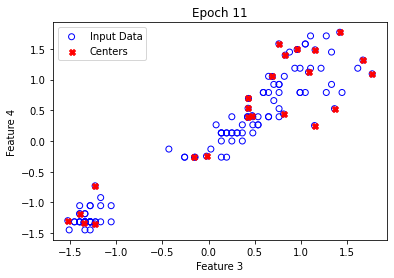

The amount of error in Epoch 12 is: 0.21159729217658352
The Number of New Centers in Epoch 12 is: 0
The Number of going through Gradient Descent in Epoch 12 is: 120
The number of centers in Epoch 12 is: 23
The Centers in Epoch 12 are as follows: 
[array([-1.42716422,  1.15972165, -1.51888638, -1.29441255]), array([ 1.25063163, -0.04221271,  0.46983597,  0.41806378]), array([-0.30590675, -1.64546091, -0.01850419, -0.2426947 ]), array([1.78300141, 1.3858077 , 1.42524277, 1.77710607]), array([ 2.43097312, -0.6084175 ,  1.78110428,  1.09448977]), array([-1.53629855,  0.33560052, -1.35474735, -1.32754457]), array([-0.4780136 , -1.62068868,  0.83896233,  1.41700367]), array([-0.15103518,  0.06946121,  0.69137877,  1.05371433]), array([0.30857111, 0.88138749, 0.96092507, 1.49391741]), array([ 0.70346404, -0.92911282,  1.09266838,  1.12949799]), array([-0.04938355, -0.55785885,  0.76062072,  1.58434916]), array([-1.0401012 ,  1.00900812, -1.23082795, -0.72671147]), array([1.32460704, 0.3427226

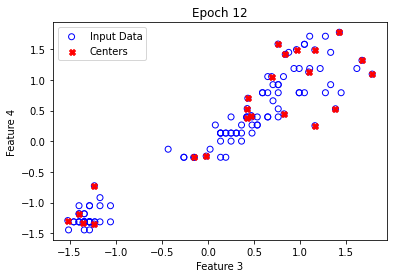

The amount of error in Epoch 13 is: 0.2110791743497092
The Number of New Centers in Epoch 13 is: 0
The Number of going through Gradient Descent in Epoch 13 is: 120
The number of centers in Epoch 13 is: 23
The Centers in Epoch 13 are as follows: 
[array([-1.41302082,  1.15731271, -1.51282318, -1.292882  ]), array([ 1.27099733, -0.05593554,  0.46680872,  0.42195912]), array([-0.28901233, -1.65347987, -0.01391918, -0.23849622]), array([1.78795821, 1.3959161 , 1.43039799, 1.78250352]), array([ 2.44400006, -0.6129089 ,  1.79092781,  1.09345163]), array([-1.53617148,  0.33488472, -1.3555923 , -1.32806014]), array([-0.49000066, -1.63346619,  0.84862557,  1.43221434]), array([-0.16694492,  0.07775926,  0.69401618,  1.05578377]), array([0.29649593, 0.89233551, 0.96392811, 1.49749789]), array([ 0.7007051 , -0.9315183 ,  1.10270692,  1.13557321]), array([-0.04975909, -0.55239598,  0.76111487,  1.58693947]), array([-1.04138515,  1.00726633, -1.23170998, -0.72484639]), array([1.32626281, 0.34457844

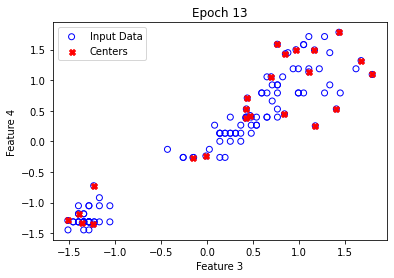

The amount of error in Epoch 14 is: 0.2105944536259374
The Number of New Centers in Epoch 14 is: 0
The Number of going through Gradient Descent in Epoch 14 is: 120
The number of centers in Epoch 14 is: 23
The Centers in Epoch 14 are as follows: 
[array([-1.39988183,  1.15484586, -1.50756808, -1.29185238]), array([ 1.28913612, -0.06839286,  0.46288476,  0.42610708]), array([-0.27305453, -1.66038089, -0.00927288, -0.2335056 ]), array([1.79258906, 1.40558002, 1.43547906, 1.78791267]), array([ 2.45659331, -0.61771801,  1.80070551,  1.09198445]), array([-1.5356952 ,  0.33401428, -1.35635484, -1.32851278]), array([-0.5002362 , -1.64606916,  0.85817595,  1.44543429]), array([-0.18052881,  0.08501016,  0.6971312 ,  1.05778994]), array([0.28501191, 0.90377047, 0.96735946, 1.50149965]), array([ 0.69830266, -0.93373357,  1.11202317,  1.14063898]), array([-0.05087579, -0.54716444,  0.76208064,  1.59066665]), array([-1.0424558 ,  1.00558887, -1.23259505, -0.72336491]), array([1.3274561 , 0.346126  

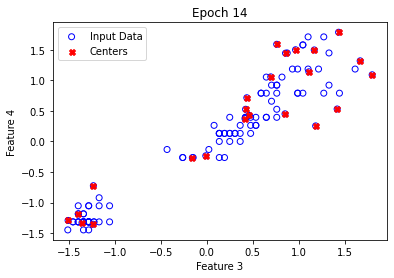

The amount of error in Epoch 15 is: 0.21017577116332256
The Number of New Centers in Epoch 15 is: 0
The Number of going through Gradient Descent in Epoch 15 is: 120
The number of centers in Epoch 15 is: 23
The Centers in Epoch 15 are as follows: 
[array([-1.38765565,  1.15233416, -1.50309177, -1.29132246]), array([ 1.30537712, -0.07968361,  0.45837217,  0.43057229]), array([-0.25805309, -1.66630254, -0.00461404, -0.22782262]), array([1.7968851 , 1.41480527, 1.44050215, 1.79335202]), array([ 2.4687449 , -0.62287964,  1.81047316,  1.09017137]), array([-1.5349132 ,  0.33293816, -1.35704394, -1.3289113 ]), array([-0.50894895, -1.65834338,  0.86764871,  1.45704512]), array([-0.19209897,  0.09134823,  0.70067566,  1.05987586]), array([0.2740705 , 0.91533064, 0.97119163, 1.5058807 ]), array([ 0.69618917, -0.93571114,  1.1207209 ,  1.14499382]), array([-0.05273556, -0.54230091,  0.76363147,  1.59534519]), array([-1.0433266 ,  1.00396641, -1.23347488, -0.72218237]), array([1.32815047, 0.3473250

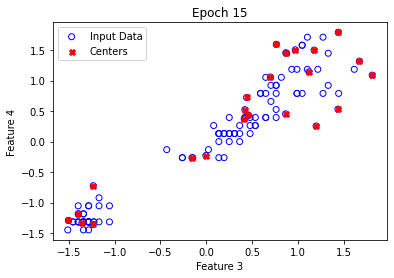

The amount of error in Epoch 16 is: 0.20986980860268825
The Number of New Centers in Epoch 16 is: 0
The Number of going through Gradient Descent in Epoch 16 is: 120
The number of centers in Epoch 16 is: 23
The Centers in Epoch 16 are as follows: 
[array([-1.37627468,  1.14982485, -1.49937171, -1.29128364]), array([ 1.32007416, -0.08988727,  0.45350351,  0.43533244]), array([-2.43941572e-01, -1.67135094e+00,  2.83021911e-05, -2.21554849e-01]), array([1.80077013, 1.42358334, 1.44546851, 1.7988463 ]), array([ 2.48042524, -0.62843123,  1.82027821,  1.08812161]), array([-1.53385818,  0.33161525, -1.3576667 , -1.32926223]), array([-0.51634238, -1.67012131,  0.87709171,  1.46740544]), array([-0.20195846,  0.09689084,  0.70459884,  1.06214807]), array([0.26359909, 0.92667394, 0.97540098, 1.5106153 ]), array([ 0.69429298, -0.93742469,  1.12889453,  1.14887968]), array([-0.05523541, -0.53787978,  0.76587325,  1.60076725]), array([-1.04400772,  1.00238946, -1.23434302, -0.7212319 ]), array([1.328

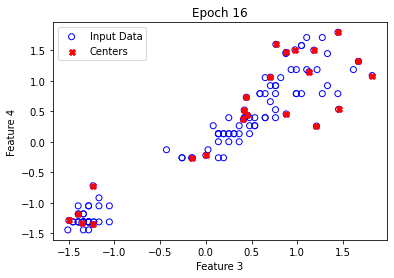

The amount of error in Epoch 17 is: 0.20977766211897633
The Number of New Centers in Epoch 17 is: 0
The Number of going through Gradient Descent in Epoch 17 is: 120
The number of centers in Epoch 17 is: 23
The Centers in Epoch 17 are as follows: 
[array([-1.365676  ,  1.14738159, -1.49638257, -1.29172016]), array([ 1.3335675 , -0.09909072,  0.44844675,  0.44031132]), array([-0.23061048, -1.67560927,  0.00463257, -0.2148151 ]), array([1.8041326 , 1.43189679, 1.4503683 , 1.80441682]), array([ 2.491593  , -0.63439745,  1.83016802,  1.08595254]), array([-1.53255671,  0.33001398, -1.35822887, -1.32957024]), array([-0.52260549, -1.68126545,  0.88655614,  1.47683939]), array([-0.21038263,  0.10174911,  0.70884531,  1.06466992]), array([0.25352562, 0.9375273 , 0.97996691, 1.51568891]), array([ 0.69255866, -0.93886608,  1.13662817,  1.15247975]), array([-0.05821833, -0.53391572,  0.76889407,  1.60676665]), array([-1.04450642,  1.00085034, -1.23519405, -0.72045657]), array([1.3279195 , 0.3486141

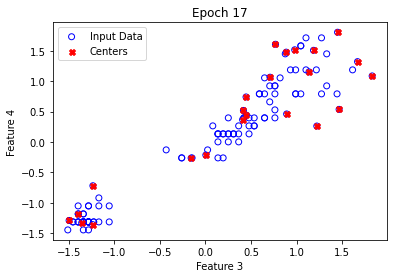

The amount of error in Epoch 18 is: 0.2098360373777814
The Number of New Centers in Epoch 18 is: 0
The Number of going through Gradient Descent in Epoch 18 is: 120
The number of centers in Epoch 18 is: 23
The Centers in Epoch 18 are as follows: 
[array([-1.35579239,  1.14506209, -1.49408036, -1.29259608]), array([ 1.34619554, -0.10735591,  0.44331853,  0.44541236]), array([-0.21793605, -1.6791501 ,  0.00917417, -0.2077243 ]), array([1.80685998, 1.43973004, 1.45518757, 1.81007745]), array([ 2.50219709, -0.64079005,  1.84017819,  1.08377145]), array([-1.53102873,  0.32811314, -1.35873496, -1.32983819]), array([-0.52790617, -1.69166467,  0.89606871,  1.48558533]), array([-0.2176129 ,  0.10600691,  0.71335057,  1.06745302]), array([0.24377884, 0.94768669, 0.98486156, 1.52107832]), array([ 0.69094225, -0.94004459,  1.14398663,  1.15591536]), array([-0.06152231, -0.53038867,  0.77274872,  1.6132147 ]), array([-1.04482741,  0.99934282, -1.23602392, -0.71981074]), array([1.32697563, 0.34871155

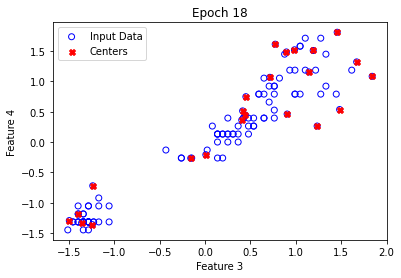

The amount of error in Epoch 19 is: 0.20997321651020998
The Number of New Centers in Epoch 19 is: 0
The Number of going through Gradient Descent in Epoch 19 is: 120
The number of centers in Epoch 19 is: 23
The Centers in Epoch 19 are as follows: 
[array([-1.3465626 ,  1.14292718, -1.4924192 , -1.29387108]), array([ 1.3582196 , -0.11474856,  0.43818991,  0.45053153]), array([-0.20580576, -1.68202445,  0.01362513, -0.20039947]), array([1.80886114, 1.44707568, 1.45991424, 1.81583618]), array([ 2.512194  , -0.64760586,  1.85033433,  1.08166976]), array([-1.52928815,  0.3259021 , -1.35918829, -1.33006725]), array([-0.53240184, -1.70126342,  0.90564322,  1.49382661]), array([-0.22385394,  0.1097379 ,  0.7180535 ,  1.07048421]), array([0.23429815, 0.95703471, 0.99005699, 1.52676287]), array([ 0.6894199 , -0.94098444,  1.15102583,  1.15926657]), array([-0.06500882, -0.52726101,  0.77745503,  1.62002744]), array([-1.04497333,  0.99786162, -1.23682989, -0.71925957]), array([1.32550642, 0.3484651

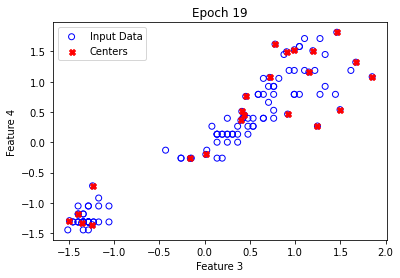

The amount of error in Epoch 20 is: 0.21013709246097914
The Number of New Centers in Epoch 20 is: 0
The Number of going through Gradient Descent in Epoch 20 is: 120
The number of centers in Epoch 20 is: 23
The Centers in Epoch 20 are as follows: 
[array([-1.33792288,  1.14102763, -1.49134857, -1.29550263]), array([ 1.36984759, -0.12134087,  0.4331048 ,  0.45558019]), array([-0.1941277 , -1.68428402,  0.01795462, -0.19295076]), array([1.81007938, 1.45393364, 1.46454202, 1.82169428]), array([ 2.52155182, -0.65482719,  1.86065089,  1.07971951]), array([-1.52734522,  0.32337913, -1.35959138, -1.33025748]), array([-0.5362357 , -1.71005436,  0.91527928,  1.50169308]), array([-0.22927235,  0.11300446,  0.72289678,  1.07373098]), array([0.22503655, 0.96552697, 0.99552562, 1.53272245]), array([ 0.68798331, -0.94171645,  1.15779239,  1.16258144]), array([-0.06857596, -0.52449088,  0.78299534,  1.62715482]), array([-1.04494537,  0.99640267, -1.23761009, -0.71877551]), array([1.32355944, 0.3478968

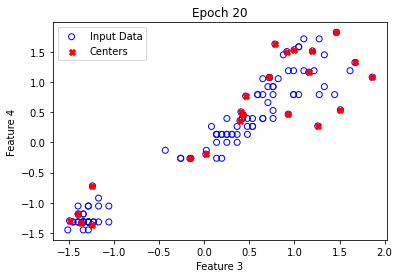

The amount of error in Epoch 21 is: 0.2103112187471051
The Number of New Centers in Epoch 21 is: 0
The Number of going through Gradient Descent in Epoch 21 is: 120
The number of centers in Epoch 21 is: 23
The Centers in Epoch 21 are as follows: 
[array([-1.32981238,  1.13941018, -1.49082151, -1.29745318]), array([ 1.381222  , -0.12721252,  0.42808975,  0.46048972]), array([-0.18283041, -1.68597463,  0.02213337, -0.18547477]), array([1.81049619, 1.46031058, 1.46907232, 1.82764766]), array([ 2.53025452, -0.6624237 ,  1.87113331,  1.07797478]), array([-1.52520696,  0.32055055, -1.35994621, -1.33040802]), array([-0.53953613, -1.71807168,  0.92496878,  1.50927741]), array([-0.23400281,  0.11586182,  0.72783082,  1.0771548 ]), array([0.21596047, 0.97317666, 1.00124247, 1.53893958]), array([ 0.68663491, -0.94227467,  1.16432657,  1.16588836]), array([-0.07215943, -0.52204112,  0.78932489,  1.63457169]), array([-1.04474347,  0.99496261, -1.23836348, -0.71833782]), array([1.32119761, 0.34703053

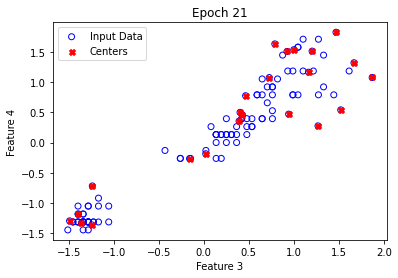

The amount of error in Epoch 22 is: 0.21049531066835214
The Number of New Centers in Epoch 22 is: 0
The Number of going through Gradient Descent in Epoch 22 is: 120
The number of centers in Epoch 22 is: 23
The Centers in Epoch 22 are as follows: 
[array([-1.32217249,  1.1381157 , -1.49079419, -1.29968988]), array([ 1.39243784, -0.13244427,  0.42316359,  0.46521496]), array([-0.1718584 , -1.68713751,  0.02613757, -0.17805139]), array([1.81012211, 1.46621123, 1.47351077, 1.83368433]), array([ 2.53829323, -0.67035227,  1.88177472,  1.07647348]), array([-1.52287756,  0.31742933, -1.36025439, -1.33051752]), array([-0.54241138, -1.72537279,  0.93469886,  1.51664272]), array([-0.23815254,  0.1183579 ,  0.73281356,  1.08071601]), array([0.2070518 , 0.98003136, 1.00718479, 1.54539585]), array([ 0.6853826 , -0.94269259,  1.17066235,  1.16920273]), array([-0.07572065, -0.51987983,  0.7963805 ,  1.64226203]), array([-1.0443665 ,  0.99353872, -1.2390898 , -0.71793177]), array([1.31849131, 0.3458903

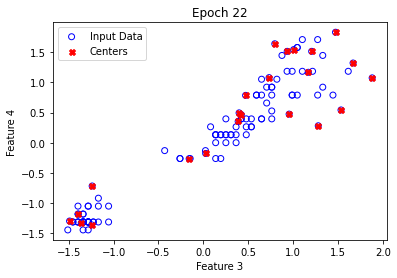

The amount of error in Epoch 23 is: 0.21069018519254967
The Number of New Centers in Epoch 23 is: 0
The Number of going through Gradient Descent in Epoch 23 is: 120
The number of centers in Epoch 23 is: 23
The Centers in Epoch 23 are as follows: 
[array([-1.3149514 ,  1.13718145, -1.49122992, -1.30218679]), array([ 1.4035421 , -0.13711577,  0.41833931,  0.46972886]), array([-0.16116965, -1.68780501,  0.02994967, -0.17074343]), array([1.80899334, 1.47164349, 1.47786788, 1.83978898]), array([ 2.54567124, -0.67856404,  1.89256263,  1.07524114]), array([-1.52035929,  0.31403395, -1.3605174 , -1.33058448]), array([-0.54495216, -1.73203078,  0.94445595,  1.52383399]), array([-0.2418078 ,  0.12053494,  0.73781111,  1.08437913]), array([0.19830261, 0.98616067, 1.01333212, 1.55207326]), array([ 0.68423632, -0.94300241,  1.17682904,  1.17253306]), array([-0.07923987, -0.5179827 ,  0.80408847,  1.65021293]), array([-1.04381248,  0.9921295 , -1.23978951, -0.71754817]), array([1.31551293, 0.3444999

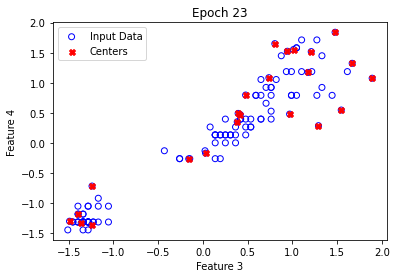

The amount of error in Epoch 24 is: 0.2109011552437042
The Number of New Centers in Epoch 24 is: 0
The Number of going through Gradient Descent in Epoch 24 is: 120
The number of centers in Epoch 24 is: 23
The Centers in Epoch 24 are as follows: 
[array([-1.30810246,  1.13663583, -1.49209675, -1.30492333]), array([ 1.41455643, -0.14130062,  0.41362952,  0.47402114]), array([-0.15073187, -1.68800456,  0.03355857, -0.16359836]), array([1.80716443, 1.47662089, 1.48215847, 1.8459469 ]), array([ 2.55240582, -0.687011  ,  1.90348434,  1.07429426]), array([-1.51765387,  0.31038618, -1.36073689, -1.33060767]), array([-0.54723441, -1.73812552,  0.95422556,  1.53088122]), array([-0.24503855,  0.12242919,  0.74279627,  1.08811338]), array([0.18970918, 0.99164575, 1.01966592, 1.5589549 ]), array([ 0.68320479, -0.94323359,  1.18285126,  1.17588362]), array([-0.0827111 , -0.51633281,  0.81237053,  1.65840994]), array([-1.04307897,  0.99073495, -1.24046375, -0.71718137]), array([1.31233145, 0.34288225

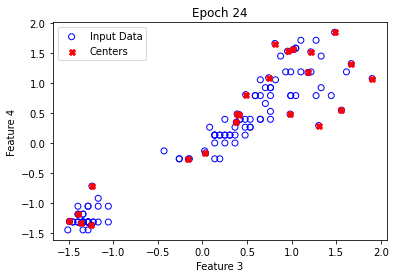

The amount of error in Epoch 25 is: 0.21113566534466102
The Number of New Centers in Epoch 25 is: 0
The Number of going through Gradient Descent in Epoch 25 is: 120
The number of centers in Epoch 25 is: 23
The Centers in Epoch 25 are as follows: 
[array([-1.3015839 ,  1.13650105, -1.49336793, -1.30788444]), array([ 1.42547921, -0.14507033,  0.4090435 ,  0.4780875 ]), array([-0.14052105, -1.68775756,  0.03695881, -0.15665103]), array([1.80469971, 1.48115718, 1.48639932, 1.85214382]), array([ 2.55851957, -0.69564493,  1.91452481,  1.07364304]), array([-1.51476357,  0.3065092 , -1.3609149 , -1.33058646]), array([-0.54931852, -1.74373514,  0.96399522,  1.53780712]), array([-0.24790088,  0.12407279,  0.74774859,  1.09189531]), array([0.18127416, 0.99656814, 1.02617004, 1.56602535]), array([ 0.6822952 , -0.94341152,  1.18874992,  1.17925761]), array([-0.08613236, -0.51491731,  0.82115082,  1.66683751]), array([-1.04216337,  0.98935668, -1.24111413, -0.71682757]), array([1.30900951, 0.3410586

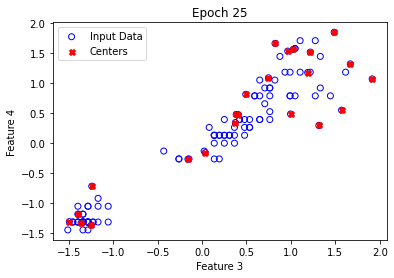

The amount of error in Epoch 26 is: 0.2113960542413255
The Number of New Centers in Epoch 26 is: 0
The Number of going through Gradient Descent in Epoch 26 is: 120
The number of centers in Epoch 26 is: 23
The Centers in Epoch 26 are as follows: 
[array([-1.29535757,  1.13679317, -1.49501804, -1.31105569]), array([ 1.43630432, -0.14848691,  0.40458708,  0.48192912]), array([-0.1305189 , -1.68708426,  0.04014831, -0.14992765]), array([1.80166715, 1.4852637 , 1.49060623, 1.85836305]), array([ 2.56403488, -0.7044176 ,  1.9256646 ,  1.07329135]), array([-1.51169035,  0.30242691, -1.36105367, -1.33052065]), array([-0.55124915, -1.74892869,  0.97375225,  1.54462373]), array([-0.25043948,  0.12549221,  0.75265213,  1.09570522]), array([0.17300494, 1.00100062, 1.03282762, 1.57326401]), array([ 0.68151178, -0.94355742,  1.19454164,  1.18265629]), array([-0.08950169, -0.51372557,  0.83035572,  1.67547044]), array([-1.04106308,  0.98799721, -1.241743  , -0.71648621]), array([1.30560195, 0.33904851

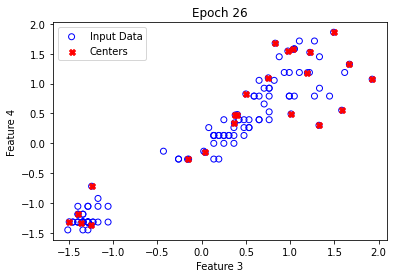

The amount of error in Epoch 27 is: 0.21168722099457005
The Number of New Centers in Epoch 27 is: 0
The Number of going through Gradient Descent in Epoch 27 is: 120
The number of centers in Epoch 27 is: 23
The Centers in Epoch 27 are as follows: 
[array([-1.28939159,  1.13752104, -1.49702496, -1.31442501]), array([ 1.44701506, -0.15160138,  0.4002606 ,  0.48554682]), array([-0.12071248, -1.68599986,  0.04312763, -0.1434473 ]), array([1.79813622, 1.48895191, 1.49479452, 1.86458894]), array([ 2.56897645, -0.7132844 ,  1.93688355,  1.07323894]), array([-1.50843728,  0.29816229, -1.36115596, -1.33041078]), array([-0.55305979, -1.75376835,  0.98348435,  1.55133665]), array([-0.25268992,  0.12670934,  0.75749604,  1.09952926]), array([0.1649111 , 1.0050081 , 1.03962263, 1.58064997]), array([ 0.680857  , -0.94368928,  1.20024033,  1.18608069]), array([-0.09281632, -0.51274967,  0.83991661,  1.6842794 ]), array([-1.03977586,  0.98666016, -1.24235331, -0.7161582 ]), array([1.3021562 , 0.3368694

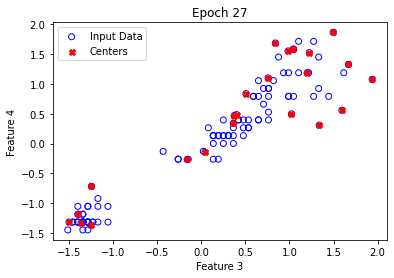

The amount of error in Epoch 28 is: 0.21204172207678348
The Number of New Centers in Epoch 28 is: 0
The Number of going through Gradient Descent in Epoch 28 is: 120
The number of centers in Epoch 28 is: 23
The Centers in Epoch 28 are as follows: 
[array([-1.28365975,  1.13868749, -1.49936992, -1.31798304]), array([ 1.45758595, -0.15445739,  0.39606242,  0.48894193]), array([-0.11109275, -1.68451595,  0.04590025, -0.13722255]), array([1.79417763, 1.49223696, 1.49897984, 1.8708092 ]), array([ 2.57337458, -0.7222062 ,  1.94816398,  1.07348284]), array([-1.5050087 ,  0.29373663, -1.36122497, -1.33025814]), array([-0.55477672, -1.75831148,  0.99318072,  1.55794966]), array([-0.25468127,  0.12774326,  0.76227333,  1.10335864]), array([0.15700192, 1.00864987, 1.04653992, 1.58816365]), array([ 0.68033193, -0.94382224,  1.20585787,  1.18953238]), array([-0.0960735 , -0.51198361,  0.8497709 ,  1.69323526]), array([-1.0383001 ,  0.98534991, -1.24294851, -0.71584506]), array([1.29871267, 0.3345375

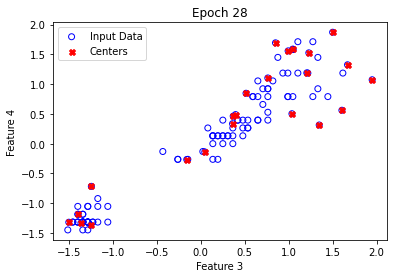

The amount of error in Epoch 29 is: 0.21243310960756195
The Number of New Centers in Epoch 29 is: 0
The Number of going through Gradient Descent in Epoch 29 is: 120
The number of centers in Epoch 29 is: 23
The Centers in Epoch 29 are as follows: 
[array([-1.27814113,  1.14029264, -1.50203784, -1.3217234 ]), array([ 1.46799224, -0.15709315,  0.39199209,  0.4921177 ]), array([-0.10165109, -1.68264392,  0.04847327, -0.13126016]), array([1.78986149, 1.4951363 , 1.50317816, 1.87701502]), array([ 2.57726406, -0.73114913,  1.95949173,  1.07401939]), array([-1.50140994,  0.28916923, -1.36126436, -1.33006465]), array([-0.5564215 , -1.76261002,  1.00283224,  1.56446586]), array([-0.25643828,  0.12861048,  0.76697934,  1.10718791]), array([0.14928548, 1.01197916, 1.05356586, 1.5957879 ]), array([ 0.67993598, -0.94396886,  1.21140435,  1.19301341]), array([-0.09927098, -0.51142282,  0.85986294,  1.70231088]), array([-1.0366351 ,  0.98407109, -1.24353268, -0.71554934]), array([1.29530517, 0.3320675

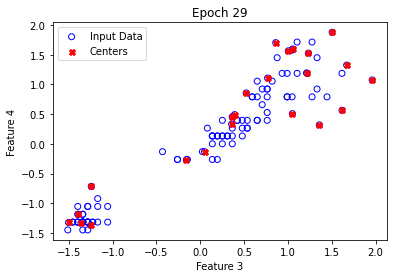

The amount of error in Epoch 30 is: 0.21283224561698216
The Number of New Centers in Epoch 30 is: 0
The Number of going through Gradient Descent in Epoch 30 is: 120
The number of centers in Epoch 30 is: 23
The Centers in Epoch 30 are as follows: 
[array([-1.27281876,  1.14233207, -1.5050146 , -1.3256399 ]), array([ 1.47821058, -0.15954239,  0.38804965,  0.49507763]), array([-0.09237924, -1.68039395,  0.05085644, -0.12556237]), array([1.78525361, 1.49766689, 1.50740356, 1.88319879]), array([ 2.58067954, -0.74008374,  1.9708533 ,  1.07484351]), array([-1.4976465 ,  0.28447832, -1.36127809, -1.32983273]), array([-0.55800982, -1.76670813,  1.01243026,  1.57088613]), array([-0.25798248,  0.1293257 ,  0.77161137,  1.11101457]), array([0.14176911, 1.0150405 , 1.06068695, 1.60350536]), array([ 0.6796673 , -0.94413981,  1.21688868,  1.19652672]), array([-0.10240532, -0.51106297,  0.870143  ,  1.71147861]), array([-1.03478089,  0.98282874, -1.24411062, -0.71527539]), array([1.2919616 , 0.3294726

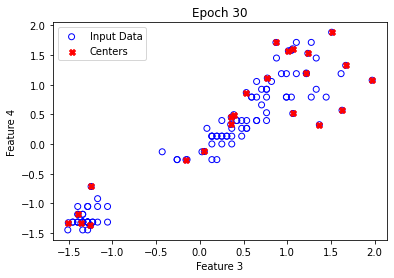

The amount of error in Epoch 31 is: 0.2132333444834019
The Number of New Centers in Epoch 31 is: 0
The Number of going through Gradient Descent in Epoch 31 is: 120
The number of centers in Epoch 31 is: 23
The Centers in Epoch 31 are as follows: 
[array([-1.26767985,  1.14479697, -1.50828732, -1.32972673]), array([ 1.48822138, -0.16183165,  0.38423339,  0.49782313]), array([-0.08326971, -1.67777586,  0.05305968, -0.12013005]), array([1.78041528, 1.49984567, 1.51166877, 1.88935467]), array([ 2.58365588, -0.74898452,  1.98223652,  1.07594947]), array([-1.49372457,  0.27968021, -1.36127056, -1.32956536]), array([-0.55955322, -1.77064332,  1.0219667 ,  1.57720997]), array([-0.25933243,  0.1299011 ,  0.77616841,  1.1148383 ]), array([0.13445928, 1.01787089, 1.06789026, 1.61129953]), array([ 0.67952254, -0.94434397,  1.22231835,  1.20007547]), array([-0.10547229, -0.51089961,  0.88056718,  1.72071177]), array([-1.03273837,  0.9816282 , -1.24468776, -0.71502823]), array([1.2887044 , 0.32676522

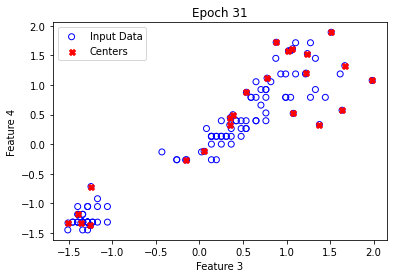

The amount of error in Epoch 32 is: 0.21155618470858423
The Number of New Centers in Epoch 32 is: 1
The Number of going through Gradient Descent in Epoch 32 is: 119
The number of centers in Epoch 32 is: 24
The Centers in Epoch 32 are as follows: 
[array([-1.26244303,  1.14684082, -1.51143558, -1.33398548]), array([ 1.49293602, -0.16919167,  0.38311961,  0.5045919 ]), array([-0.07134519, -1.67258947,  0.05885998, -0.10943447]), array([1.77608961, 1.50172228, 1.51577086, 1.895163  ]), array([ 2.58892658, -0.75631058,  1.99438427,  1.07748013]), array([-1.48960009,  0.27479454, -1.36121065, -1.32923643]), array([-0.56341053, -1.77657516,  1.03128145,  1.5837506 ]), array([-0.2616156 ,  0.13242777,  0.7801447 ,  1.11836188]), array([0.12843376, 1.02434126, 1.07558414, 1.62028936]), array([ 0.68070826, -0.94481095,  1.22863224,  1.20406917]), array([-0.11002388, -0.50978926,  0.8913694 ,  1.73282096]), array([-1.03048765,  0.98047062, -1.24524709, -0.71483083]), array([1.28790429, 0.3261381

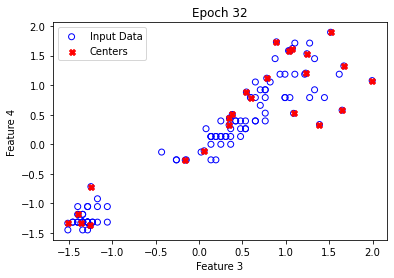

The amount of error in Epoch 33 is: 0.2047709420252697
The Number of New Centers in Epoch 33 is: 0
The Number of going through Gradient Descent in Epoch 33 is: 120
The number of centers in Epoch 33 is: 24
The Centers in Epoch 33 are as follows: 
[array([-1.25810664,  1.14767571, -1.51428454, -1.33793795]), array([ 1.49329072, -0.18393746,  0.38108195,  0.50813732]), array([-0.05042713, -1.66034061,  0.06975722, -0.09365175]), array([1.77207007, 1.50278642, 1.52010674, 1.9008092 ]), array([ 2.59894757, -0.76010212,  2.00924837,  1.0816789 ]), array([-1.4852536 ,  0.26967941, -1.36099113, -1.3287876 ]), array([-0.57200655, -1.78548362,  1.0400326 ,  1.59115807]), array([-0.26666949,  0.13861014,  0.78378718,  1.12358589]), array([0.12368268, 1.03678117, 1.08464562, 1.63269509]), array([ 0.68287768, -0.94516436,  1.23677205,  1.21058341]), array([-0.11842799, -0.50589104,  0.90293338,  1.75091102]), array([-1.02800326,  0.979253  , -1.2457103 , -0.71457367]), array([1.29077655, 0.32988567

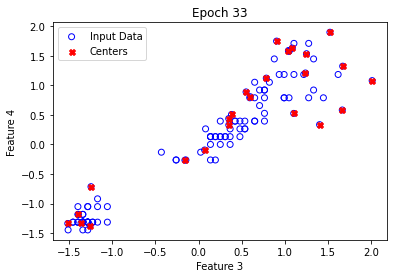

The amount of error in Epoch 34 is: 0.20909344606286734
The Number of New Centers in Epoch 34 is: 0
The Number of going through Gradient Descent in Epoch 34 is: 120
The number of centers in Epoch 34 is: 24
The Centers in Epoch 34 are as follows: 
[array([-1.25443004,  1.14858493, -1.51767172, -1.34208681]), array([ 1.49325777, -0.19370779,  0.37542089,  0.50876585]), array([-0.02751171, -1.64312298,  0.08018878, -0.07819692]), array([1.7682871 , 1.50283824, 1.52496083, 1.90652899]), array([ 2.60920784, -0.76287485,  2.02430758,  1.0866719 ]), array([-1.48071569,  0.26444772, -1.36069524, -1.32825516]), array([-0.58106553, -1.79546302,  1.04812239,  1.597423  ]), array([-0.27185984,  0.14416673,  0.78752556,  1.12929863]), array([0.11993576, 1.05010315, 1.0946565 , 1.64650637]), array([ 0.68544971, -0.94610319,  1.24487356,  1.21719832]), array([-0.12729967, -0.50276896,  0.91466043,  1.76961341]), array([-1.02531155,  0.97800937, -1.24614299, -0.71429926]), array([1.29544401, 0.3347555

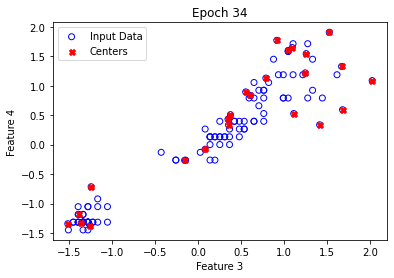

The amount of error in Epoch 35 is: 0.21081967628931872
The Number of New Centers in Epoch 35 is: 0
The Number of going through Gradient Descent in Epoch 35 is: 120
The number of centers in Epoch 35 is: 24
The Centers in Epoch 35 are as follows: 
[array([-1.25078937,  1.1500777 , -1.52141907, -1.34635746]), array([ 1.49562553, -0.19742637,  0.36709651,  0.50825808]), array([-0.00585729, -1.62473122,  0.08812079, -0.06502194]), array([1.76443717, 1.50222326, 1.53025554, 1.91234629]), array([ 2.61771225, -0.76609431,  2.03868937,  1.09148459]), array([-1.47593988,  0.25927192, -1.36035938, -1.32765336]), array([-0.58893732, -1.80507165,  1.05595574,  1.60243181]), array([-0.27634616,  0.14803166,  0.79132776,  1.13465731]), array([0.11636261, 1.06169688, 1.10486135, 1.65998958]), array([ 0.68781136, -0.94744757,  1.252256  ,  1.22302677]), array([-0.13541336, -0.50123123,  0.92623046,  1.78645099]), array([-1.02243037,  0.97676385, -1.24658747, -0.71409124]), array([1.30024136, 0.3390690

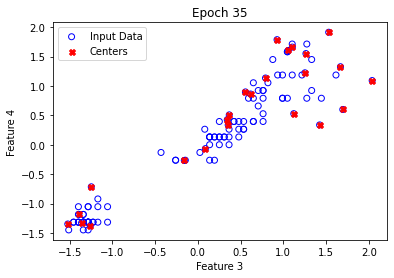

The amount of error in Epoch 36 is: 0.21127388679585843
The Number of New Centers in Epoch 36 is: 0
The Number of going through Gradient Descent in Epoch 36 is: 120
The number of centers in Epoch 36 is: 24
The Centers in Epoch 36 are as follows: 
[array([-1.24696055,  1.15250103, -1.52541825, -1.35069713]), array([ 1.49966136, -0.19755207,  0.35774414,  0.50770978]), array([ 0.01323566, -1.60739052,  0.09349498, -0.05419769]), array([1.76033787, 1.50133531, 1.53574154, 1.9182172 ]), array([ 2.62427989, -0.77033008,  2.05228195,  1.09573739]), array([-1.47097775,  0.25416376, -1.36001565, -1.32700438]), array([-0.59541723, -1.81373204,  1.06391148,  1.60683933]), array([-0.28002325,  0.15061957,  0.79508401,  1.13943586]), array([0.11244042, 1.07108228, 1.11470755, 1.67238006]), array([ 0.68984705, -0.94883877,  1.25883331,  1.22800033]), array([-0.14253713, -0.50079777,  0.93745838,  1.80107434]), array([-1.01936526,  0.97554375, -1.24705297, -0.71391726]), array([1.30436981, 0.3422986

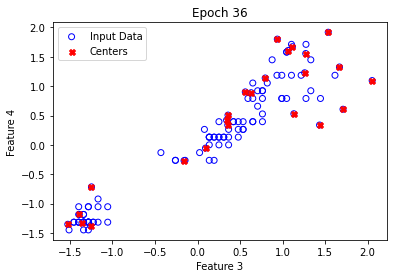

The amount of error in Epoch 37 is: 0.21109855614897086
The Number of New Centers in Epoch 37 is: 0
The Number of going through Gradient Descent in Epoch 37 is: 120
The number of centers in Epoch 37 is: 24
The Centers in Epoch 37 are as follows: 
[array([-1.24285615,  1.15584897, -1.52954933, -1.35506719]), array([ 1.50475073, -0.19633039,  0.3485661 ,  0.50774403]), array([ 0.02977188, -1.59200507,  0.09695179, -0.04515708]), array([1.75593021, 1.50035544, 1.54125042, 1.92407996]), array([ 2.62925555, -0.77555662,  2.06520858,  1.09942416]), array([-1.4658551 ,  0.24913912, -1.35968032, -1.32632221]), array([-0.60074577, -1.82136944,  1.0721102 ,  1.61106529]), array([-0.28302073,  0.15246551,  0.79869605,  1.14363971]), array([0.10805231, 1.07858895, 1.12399039, 1.68355582]), array([ 0.69159634, -0.95008752,  1.26471979,  1.23228749]), array([-0.14879373, -0.50094112,  0.94830575,  1.81384623]), array([-1.01611631,  0.97437205, -1.24754593, -0.71377785]), array([1.30764493, 0.3444884

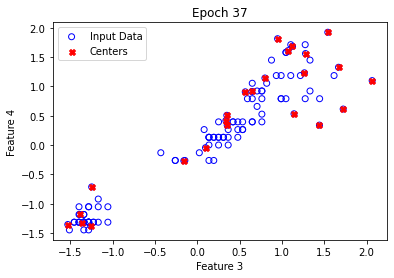

The amount of error in Epoch 38 is: 0.20973143430460753
The Number of New Centers in Epoch 38 is: 1
The Number of going through Gradient Descent in Epoch 38 is: 119
The number of centers in Epoch 38 is: 25
The Centers in Epoch 38 are as follows: 
[array([-1.23849378,  1.16022018, -1.53466782, -1.36058214]), array([ 1.50998438, -0.18193021,  0.33977842,  0.51215373]), array([ 0.0409264 , -1.57318029,  0.09690114, -0.03739775]), array([1.75330721, 1.50097268, 1.5478579 , 1.93096626]), array([ 2.63148706, -0.78555593,  2.07644885,  1.10074943]), array([-1.46059996,  0.24419931, -1.35938225, -1.32565312]), array([-0.60281907, -1.83020619,  1.0799942 ,  1.612665  ]), array([-0.28532259,  0.15163347,  0.80222124,  1.14679056]), array([0.10245119, 1.08415592, 1.13316108, 1.693965  ]), array([ 0.69310572, -0.95309928,  1.26961782,  1.23499224]), array([-0.15399604, -0.50577806,  0.95857929,  1.82358729]), array([-1.01265009,  0.97333668, -1.24808568, -0.71367035]), array([1.31065493, 0.3448307

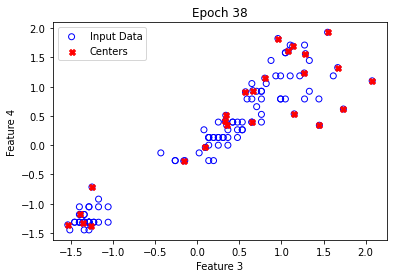

The amount of error in Epoch 39 is: 0.20501681892120455
The Number of New Centers in Epoch 39 is: 0
The Number of going through Gradient Descent in Epoch 39 is: 120
The number of centers in Epoch 39 is: 25
The Centers in Epoch 39 are as follows: 
[array([-1.23396248,  1.16653764, -1.54062329, -1.36673429]), array([ 1.51458588, -0.16973599,  0.33231309,  0.51611413]), array([ 0.04850813, -1.55708601,  0.09592445, -0.03136291]), array([1.7501012 , 1.50148683, 1.55435976, 1.93806139]), array([ 2.63171042, -0.7967966 ,  2.08662682,  1.10181432]), array([-1.45513065,  0.23955075, -1.35913432, -1.32498133]), array([-0.60296044, -1.83807604,  1.08844369,  1.61503545]), array([-0.28668293,  0.15082447,  0.80572136,  1.14996739]), array([0.09699349, 1.08833587, 1.14195008, 1.70383121]), array([ 0.69466484, -0.95594807,  1.27411655,  1.23755887]), array([-0.15744129, -0.51091736,  0.96873161,  1.83244776]), array([-1.00898326,  0.97244998, -1.24870287, -0.71376305]), array([1.3125662 , 0.3441784

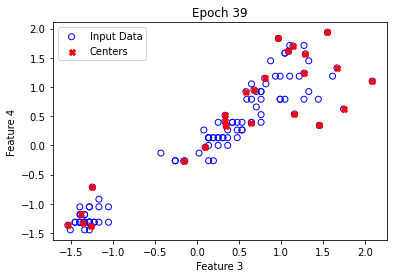

The amount of error in Epoch 40 is: 0.20464123366900258
The Number of New Centers in Epoch 40 is: 0
The Number of going through Gradient Descent in Epoch 40 is: 120
The number of centers in Epoch 40 is: 25
The Centers in Epoch 40 are as follows: 
[array([-1.22885939,  1.17331848, -1.54647931, -1.37285274]), array([ 1.52038482, -0.15863323,  0.32662181,  0.52131237]), array([ 0.05378663, -1.54344425,  0.09451544, -0.0258961 ]), array([1.74641175, 1.50224028, 1.56074962, 1.9452274 ]), array([ 2.63044743, -0.80894386,  2.0960057 ,  1.10233007]), array([-1.44952324,  0.23506212, -1.35893879, -1.32431765]), array([-0.60181971, -1.84498358,  1.09688989,  1.61720179]), array([-0.28746429,  0.14988819,  0.80897749,  1.15273118]), array([0.09141511, 1.09143868, 1.15015237, 1.71273024]), array([ 0.69600597, -0.95866643,  1.27814013,  1.23971952]), array([-0.15992304, -0.51614273,  0.97842109,  1.83997386]), array([-1.00511615,  0.97170202, -1.24939477, -0.71398268]), array([1.31350104, 0.3428976

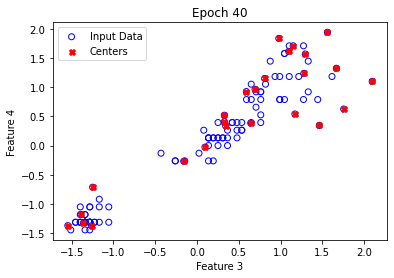

The amount of error in Epoch 41 is: 0.20475428613190508
The Number of New Centers in Epoch 41 is: 0
The Number of going through Gradient Descent in Epoch 41 is: 120
The number of centers in Epoch 41 is: 25
The Centers in Epoch 41 are as follows: 
[array([-1.22324819,  1.18021085, -1.55219426, -1.37892741]), array([ 1.52725096, -0.14722346,  0.32245297,  0.5279244 ]), array([ 0.05713478, -1.53132533,  0.09266183, -0.02070078]), array([1.74243863, 1.50349677, 1.56717713, 1.95262176]), array([ 2.62785106, -0.82216037,  2.10473813,  1.10219159]), array([-1.44383308,  0.23066592, -1.35880731, -1.32367651]), array([-0.59953253, -1.85114166,  1.10512019,  1.61874001]), array([-0.28783215,  0.14858389,  0.81202341,  1.15506127]), array([0.08558145, 1.0935478 , 1.15787946, 1.72077909]), array([ 0.69702119, -0.96144106,  1.28169668,  1.24139509]), array([-0.16172412, -0.52175954,  0.98755637,  1.84603302]), array([-1.0010575 ,  0.97110315, -1.25017102, -0.71429701]), array([1.31354512, 0.341034 

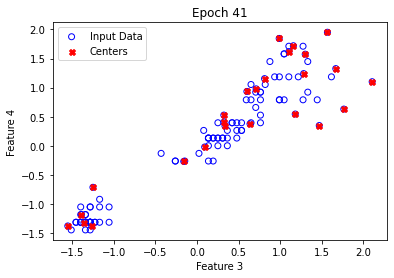

The amount of error in Epoch 42 is: 0.20536558970732963
The Number of New Centers in Epoch 42 is: 0
The Number of going through Gradient Descent in Epoch 42 is: 120
The number of centers in Epoch 42 is: 25
The Centers in Epoch 42 are as follows: 
[array([-1.21716078,  1.18726666, -1.55774563, -1.3849698 ]), array([ 1.53458354, -0.13606327,  0.31952417,  0.53573956]), array([ 0.05894801, -1.52040144,  0.09054553, -0.01546969]), array([1.73829248, 1.50530924, 1.57366179, 1.96020227]), array([ 2.62430985, -0.83607727,  2.11304218,  1.10151183]), array([-1.43810207,  0.22633933, -1.35874895, -1.32307008]), array([-0.59641472, -1.85669382,  1.11312322,  1.61967517]), array([-0.28788882,  0.14706599,  0.8149114 ,  1.15704618]), array([0.07961412, 1.09503008, 1.16523381, 1.7281041 ]), array([ 0.69773243, -0.96423361,  1.28489501,  1.2426653 ]), array([-0.16303887, -0.52754155,  0.99618397,  1.85086121]), array([-0.99682269,  0.97067177, -1.25104156, -0.71469181]), array([1.31286817, 0.3388095

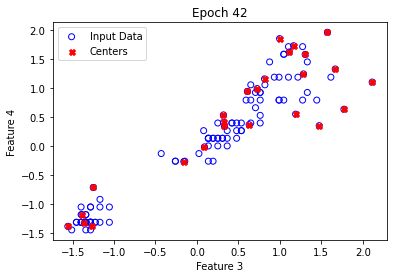

The amount of error in Epoch 43 is: 0.20613195320661398
The Number of New Centers in Epoch 43 is: 0
The Number of going through Gradient Descent in Epoch 43 is: 120
The number of centers in Epoch 43 is: 25
The Centers in Epoch 43 are as follows: 
[array([-1.21068634,  1.1946545 , -1.56313086, -1.39096919]), array([ 1.54175058, -0.12632846,  0.31749217,  0.54423043]), array([ 0.05965756, -1.51063083,  0.08837475, -0.01008117]), array([1.73401891, 1.50754927, 1.58012435, 1.96779456]), array([ 2.62024925, -0.85008552,  2.1210923 ,  1.10051622]), array([-1.4323626 ,  0.2220705 , -1.35876842, -1.32250676]), array([-0.59283521, -1.86171645,  1.1209756 ,  1.62026565]), array([-0.28770231,  0.1456008 ,  0.81769526,  1.15882971]), array([0.07374865, 1.09628609, 1.17228995, 1.73482636]), array([ 0.69822537, -0.96690948,  1.287876  ,  1.24369453]), array([-0.16398944, -0.53306381,  1.00441491,  1.85485822]), array([-0.99243159,  0.97041913, -1.25201371, -0.71516296]), array([1.3116744 , 0.3364770

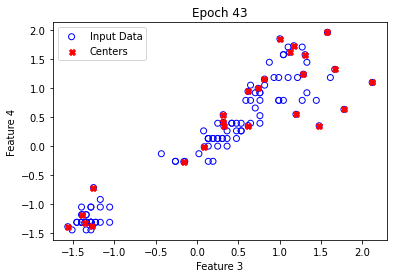

The amount of error in Epoch 44 is: 0.2066522242738289
The Number of New Centers in Epoch 44 is: 0
The Number of going through Gradient Descent in Epoch 44 is: 120
The number of centers in Epoch 44 is: 25
The Centers in Epoch 44 are as follows: 
[array([-1.20396401,  1.20244509, -1.56834451, -1.39688097]), array([ 1.54844249, -0.11886631,  0.31603853,  0.5528323 ]), array([ 0.05971853, -1.50200737,  0.08630257, -0.00458097]), array([1.7296319 , 1.51001634, 1.58646207, 1.97520928]), array([ 2.61598555, -0.86363918,  2.12898845,  1.09943153]), array([-1.42663786,  0.21784809, -1.358867  , -1.32199143]), array([-0.58911334, -1.86624304,  1.12873746,  1.62076695]), array([-0.28733361,  0.14437504,  0.82041505,  1.16054573]), array([0.06818497, 1.09758219, 1.17909369, 1.74104916]), array([ 0.69858337, -0.96935108,  1.29076099,  1.24465106]), array([-0.16466744, -0.53798992,  1.01235598,  1.85838608]), array([-0.98790851,  0.97034375, -1.25309397, -0.71571565]), array([1.31014629, 0.33421776

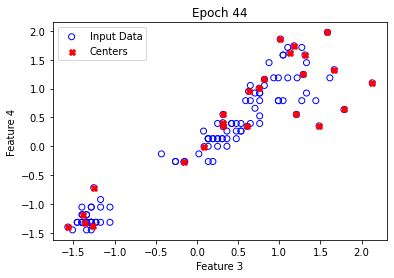

The amount of error in Epoch 45 is: 0.20691540531103667
The Number of New Centers in Epoch 45 is: 0
The Number of going through Gradient Descent in Epoch 45 is: 120
The number of centers in Epoch 45 is: 25
The Centers in Epoch 45 are as follows: 
[array([-1.19715732,  1.210583  , -1.57338843, -1.40265687]), array([ 1.55463947, -0.113916  ,  0.31491026,  0.56110758]), array([ 5.95515635e-02, -1.49442263e+00,  8.44092001e-02,  9.14009503e-04]), array([1.72514746, 1.51253345, 1.59260544, 1.98232111]), array([ 2.61171637, -0.87639272,  2.13678712,  1.09843346]), array([-1.42094517,  0.21365626, -1.35904459, -1.32152708]), array([-0.5854841 , -1.87030779,  1.13642156,  1.62133344]), array([-0.28684523,  0.14345044,  0.82309694,  1.16229072]), array([0.06302809, 1.09904049, 1.18568031, 1.74686914]), array([ 0.6988597 , -0.97150506,  1.29363323,  1.24566267]), array([-0.16515985, -0.54216879,  1.02008327,  1.86169736]), array([-0.98328051,  0.97043365, -1.25428907, -0.71635778]), array([1.308

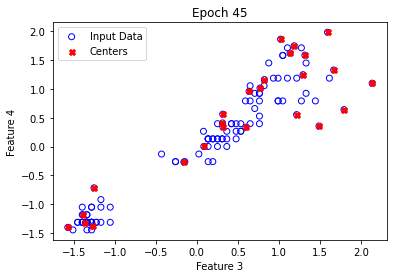

The amount of error in Epoch 46 is: 0.20700979144348614
The Number of New Centers in Epoch 46 is: 0
The Number of going through Gradient Descent in Epoch 46 is: 120
The number of centers in Epoch 46 is: 25
The Centers in Epoch 46 are as follows: 
[array([-1.19042514,  1.21895575, -1.57828689, -1.40827555]), array([ 1.56043505, -0.11122995,  0.31392734,  0.56879198]), array([ 0.0594773 , -1.48765228,  0.08271243,  0.00629031]), array([1.72060093, 1.51499015, 1.59853428, 1.98908686]), array([ 2.60755606, -0.88821249,  2.14452777,  1.09763127]), array([-1.41529913,  0.20947659, -1.35930174, -1.3211166 ]), array([-0.5820972 , -1.87397278,  1.14400854,  1.6220199 ]), array([-0.28629343,  0.14279637,  0.8257583 ,  1.16412166]), array([0.05829499, 1.10068808, 1.19208594, 1.75238042]), array([ 0.69908158, -0.97338062,  1.29654052,  1.24680523]), array([-0.16554965, -0.54561435,  1.02764326,  1.86494009]), array([-0.9785753 ,  0.9706731 , -1.25560657, -0.71709517]), array([1.30660359, 0.3302108

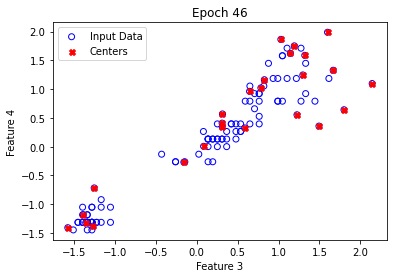

The amount of error in Epoch 47 is: 0.20701118689104211
The Number of New Centers in Epoch 47 is: 0
The Number of going through Gradient Descent in Epoch 47 is: 120
The number of centers in Epoch 47 is: 25
The Centers in Epoch 47 are as follows: 
[array([-1.18389291,  1.22744753, -1.58307488, -1.41373873]), array([ 1.565947  , -0.11035787,  0.31297991,  0.57576768]), array([ 0.05970184, -1.48144835,  0.08119985,  0.01146826]), array([1.71603546, 1.51732629, 1.60425986, 1.99551584]), array([ 2.60356088, -0.89910042,  2.15223536,  1.09708187]), array([-1.40971086,  0.20529367, -1.35964017, -1.3207634 ]), array([-0.57903197, -1.87731151,  1.15146908,  1.6228237 ]), array([-0.28571957,  0.14234555,  0.82840941,  1.16606533]), array([0.05395538, 1.10250342, 1.19834374, 1.75766437]), array([ 0.69926354, -0.97501887,  1.29950597,  1.24811486]), array([-0.16590296, -0.54842495,  1.03506241,  1.86819006]), array([-0.97381959,  0.97104644, -1.25705489, -0.71793354]), array([1.30475523, 0.3284636

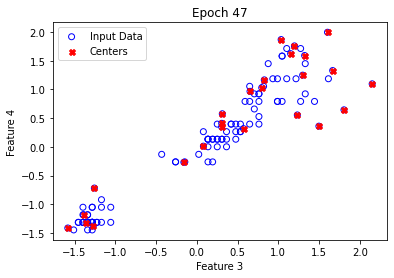

The amount of error in Epoch 48 is: 0.20697536246218037
The Number of New Centers in Epoch 48 is: 0
The Number of going through Gradient Descent in Epoch 48 is: 120
The number of centers in Epoch 48 is: 25
The Centers in Epoch 48 are as follows: 
[array([-1.17764359,  1.23596251, -1.5877871 , -1.41906137]), array([ 1.57127646, -0.11082272,  0.31201413,  0.5820207 ]), array([ 0.06033096, -1.47559359,  0.07984834,  0.01640454]), array([1.71149402, 1.51951205, 1.60980725, 2.00164122]), array([ 2.59975042, -0.90913004,  2.15992055,  1.09680413]), array([-1.40418849,  0.20109735, -1.36006291, -1.32047159]), array([-0.57631615, -1.88039536,  1.15877532,  1.62371509]), array([-0.28514814,  0.1420267 ,  0.83105532,  1.16812841]), array([0.04996128, 1.10444461, 1.20447959, 1.7627825 ]), array([ 0.69941613, -0.97647084,  1.30253714,  1.24960129]), array([-0.16626385, -0.55072745,  1.04235395,  1.87147669]), array([-0.96903798,  0.9715406 , -1.25864318, -0.71887949]), array([1.30292301, 0.3268452

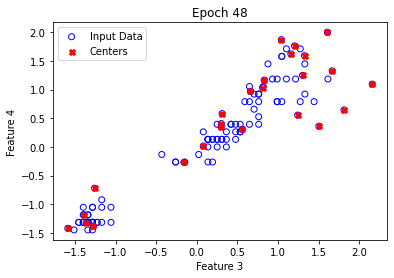

The amount of error in Epoch 49 is: 0.20693414482752803
The Number of New Centers in Epoch 49 is: 0
The Number of going through Gradient Descent in Epoch 49 is: 120
The number of centers in Epoch 49 is: 25
The Centers in Epoch 49 are as follows: 
[array([-1.17172309,  1.24443241, -1.59245433, -1.42426438]), array([ 1.57648683, -0.11220737,  0.31100976,  0.58759185]), array([ 0.06139407, -1.4699197 ,  0.07863206,  0.02108116]), array([1.70701409, 1.52153381, 1.61520324, 2.00750149]), array([ 2.59612311, -0.91840001,  2.1675814 ,  1.09679317]), array([-1.39873767,  0.19688266, -1.3605741 , -1.32024607]), array([-0.57394392, -1.88328634,  1.16590692,  1.62465851]), array([-0.28458923,  0.14177966,  0.83369836,  1.17030695]), array([0.04626547, 1.10646669, 1.21051188, 1.76777768]), array([ 0.69955003, -0.9777845 ,  1.30563306,  1.25125951]), array([-0.16665497, -0.5526438 ,  1.04952411,  1.87480469]), array([-0.96425228,  0.97214607, -1.26038074, -0.71993997]), array([1.30113656, 0.3253164

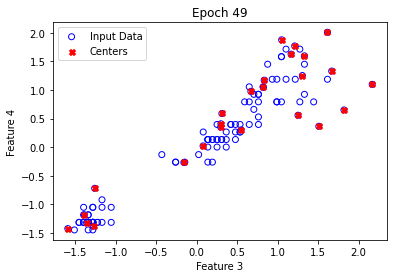

The amount of error in Epoch 50 is: 0.20690453312210097
The Number of New Centers in Epoch 50 is: 0
The Number of going through Gradient Descent in Epoch 50 is: 120
The number of centers in Epoch 50 is: 25
The Centers in Epoch 50 are as follows: 
[array([-1.16615044,  1.25281589, -1.59710337, -1.42937094]), array([ 1.58160873, -0.11418792,  0.30996914,  0.59254722]), array([ 0.06287383, -1.46430982,  0.07752961,  0.02549763]), array([1.70262563, 1.52338714, 1.62047126, 2.01313266]), array([ 2.5926702 , -0.92700893,  2.17521007,  1.09703293]), array([-1.3933621 ,  0.19264891, -1.3611786 , -1.32009219]), array([-0.57189227, -1.88603515,  1.1728532 ,  1.62562511]), array([-0.28404381,  0.14156019,  0.83633896,  1.17259205]), array([0.04282784, 1.10853172, 1.21645299, 1.77267918]), array([ 0.69967644, -0.97899927,  1.30878884,  1.25307801]), array([-0.16708378, -0.55427556,  1.05657655,  1.87816991]), array([-0.95948143,  0.97285627, -1.2622766 , -0.72112244]), array([1.29941504, 0.3238426

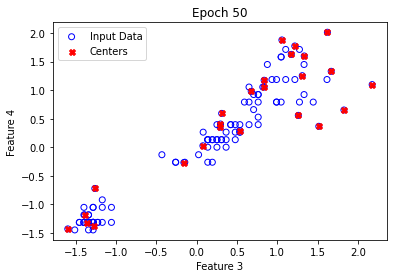

The amount of error in Epoch 51 is: 0.20689744301655866
The Number of New Centers in Epoch 51 is: 0
The Number of going through Gradient Descent in Epoch 51 is: 120
The number of centers in Epoch 51 is: 25
The Centers in Epoch 51 are as follows: 
[array([-1.1609262 ,  1.26109133, -1.60175559, -1.43440268]), array([ 1.58665227, -0.11652907,  0.30890637,  0.59695979]), array([ 0.06472728, -1.45869129,  0.07652453,  0.02966274]), array([1.69835095, 1.52507161, 1.6256296 , 2.0185648 ]), array([ 2.58938014, -0.93504436,  2.18279519,  1.09750281]), array([-1.38806403,  0.18839882, -1.36188178, -1.32001568]), array([-0.57013007, -1.88868067,  1.17961102,  1.62659458]), array([-0.28350742,  0.14133832,  0.83897637,  1.17497304]), array([0.039617  , 1.11060994, 1.22231047, 1.77750583]), array([ 0.69980653, -0.9801451 ,  1.31199798,  1.25504318]), array([-0.1675476 , -0.55570169,  1.06351394,  1.88156521]), array([-0.95474181,  0.97366702, -1.2643393 , -0.72243484]), array([1.29777035, 0.3223951

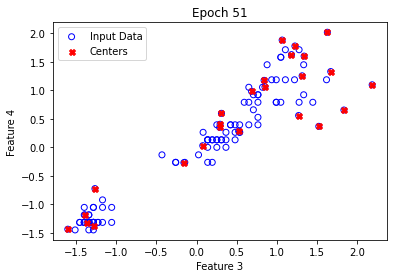

The amount of error in Epoch 52 is: 0.20691943686722214
The Number of New Centers in Epoch 52 is: 0
The Number of going through Gradient Descent in Epoch 52 is: 120
The number of centers in Epoch 52 is: 25
The Centers in Epoch 52 are as follows: 
[array([-1.15603992,  1.26924827, -1.60642725, -1.43937804]), array([ 1.59161616, -0.1190649 ,  0.30784278,  0.60090078]), array([ 0.06690161, -1.45302257,  0.07560572,  0.03359017]), array([1.69420586, 1.52658969, 1.63069161, 2.02382223]), array([ 2.58624205, -0.94258099,  2.19032462,  1.09818105]), array([-1.38284484,  0.18413716, -1.3626893 , -1.32002245]), array([-0.56862456, -1.89125221,  1.18618198,  1.62755382]), array([-0.28297368,  0.14109489,  0.84160909,  1.17743917]), array([0.03660814, 1.11267925, 1.228088  , 1.78226925]), array([ 0.69995029, -0.9812441 ,  1.31525349,  1.25714152]), array([-0.16803889, -0.5569814 ,  1.07033798,  1.88498301]), array([-0.95004753,  0.97457571, -1.26657674, -0.72388496]), array([1.29620924, 0.3209521

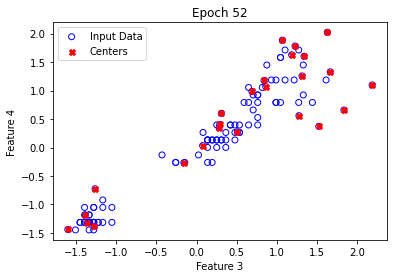

The amount of error in Epoch 53 is: 0.20697499278662929
The Number of New Centers in Epoch 53 is: 0
The Number of going through Gradient Descent in Epoch 53 is: 120
The number of centers in Epoch 53 is: 25
The Centers in Epoch 53 are as follows: 
[array([-1.15147515,  1.27728441, -1.61113078, -1.44431238]), array([ 1.59649077, -0.12168316,  0.30680063,  0.60443283]), array([ 0.06934124, -1.4472835 ,  0.07476521,  0.03729439]), array([1.69020069, 1.5279454 , 1.63566646, 2.02892417]), array([ 2.58324653, -0.94968043,  2.19778672,  1.09904701]), array([-1.37770558,  0.1798699 , -1.36360702, -1.32011861]), array([-0.56734403, -1.8937711 ,  1.19257116,  1.62849623]), array([-0.28243575,  0.14081869,  0.84423552,  1.17998076]), array([0.03378208, 1.11472402, 1.23378705, 1.7869766 ]), array([ 0.70011626, -0.98231198,  1.31854864,  1.25936082]), array([-0.16854767, -0.55815758,  1.07705029,  1.88841705]), array([-0.9454108 ,  0.97558097, -1.26899603, -0.72548013]), array([1.2947348 , 0.3194971

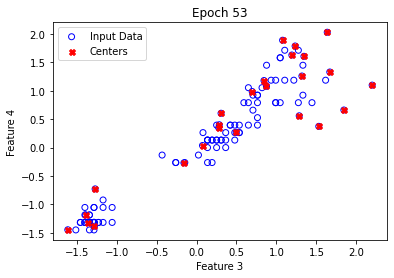

The amount of error in Epoch 54 is: 0.20706695634938646
The Number of New Centers in Epoch 54 is: 0
The Number of going through Gradient Descent in Epoch 54 is: 120
The number of centers in Epoch 54 is: 25
The Centers in Epoch 54 are as follows: 
[array([-1.14721269,  1.28520248, -1.61587552, -1.44921805]), array([ 1.60126548, -0.12430966,  0.30580133,  0.60760934]), array([ 0.0719933 , -1.44146882,  0.07399723,  0.04078879]), array([1.68634127, 1.52914384, 1.64056028, 2.03388617]), array([ 2.58038582, -0.9563933 ,  2.20517145,  1.10008226]), array([-1.3726469 ,  0.17560405, -1.36464087, -1.3203103 ]), array([-0.56625941, -1.89625251,  1.19878583,  1.62942009]), array([-0.28188731,  0.14050358,  0.84685393,  1.18258908]), array([0.0311234 , 1.11673342, 1.2394076 , 1.79163239]), array([ 0.70031111, -0.98335963,  1.32187709,  1.26169041]), array([-0.16906361, -0.55926068,  1.0836525 ,  1.8918626 ]), array([-0.9408422 ,  0.97668216, -1.27160354, -0.72722729]), array([1.29334743, 0.3180181

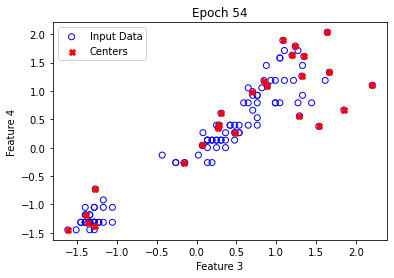

The amount of error in Epoch 55 is: 0.20719593854968157
The Number of New Centers in Epoch 55 is: 0
The Number of going through Gradient Descent in Epoch 55 is: 120
The number of centers in Epoch 55 is: 25
The Centers in Epoch 55 are as follows: 
[array([-1.14323287,  1.29300778, -1.62066834, -1.45410484]), array([ 1.60593015, -0.12689758,  0.30486427,  0.61047486]), array([ 0.07481016, -1.43558224,  0.07329767,  0.04408545]), array([1.68263022, 1.53019114, 1.64537707, 2.03872104]), array([ 2.57765367, -0.96276127,  2.2124707 ,  1.10127077]), array([-1.36766932,  0.17134729, -1.36579677, -1.32060371]), array([-0.56534498, -1.89870721,  1.20483427,  1.6303268 ]), array([-0.28132307,  0.14014698,  0.84946272,  1.18525662]), array([0.02861931, 1.11870042, 1.24494888, 1.79623955]), array([ 0.7005399 , -0.98439464,  1.32523326,  1.26412129]), array([-0.16957732, -0.56031224,  1.09014637,  1.89531659]), array([-0.93635089,  0.97787921, -1.27440484, -0.72913297]), array([1.29204602, 0.3165070

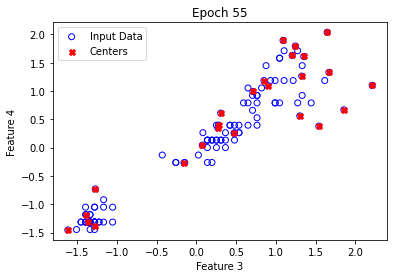

The amount of error in Epoch 56 is: 0.2073597827012334
The Number of New Centers in Epoch 56 is: 0
The Number of going through Gradient Descent in Epoch 56 is: 120
The number of centers in Epoch 56 is: 25
The Centers in Epoch 56 are as follows: 
[array([-1.13951645,  1.30070644, -1.62551378, -1.45897995]), array([ 1.61047713, -0.12941847,  0.30400572,  0.61306581]), array([ 0.07775016, -1.42963329,  0.07266316,  0.04719455]), array([1.67906735, 1.53109299, 1.65011915, 2.04343899]), array([ 2.57504374, -0.96881843,  2.21967735,  1.10259873]), array([-1.36277337,  0.16710775, -1.3670807 , -1.32100504]), array([-0.56457798, -1.90114206,  1.21072519,  1.63121962]), array([-0.28073893,  0.13974852,  0.85206047,  1.1879769 ]), array([0.02625917, 1.12061983, 1.25040975, 1.8007998 ]), array([ 0.70080622, -0.98542212,  1.32861228,  1.266646  ]), array([-0.17008029, -0.56132731,  1.0965338 ,  1.89877667]), array([-0.93194496,  0.97917232, -1.27740477, -0.73120327]), array([1.29082836, 0.31495798

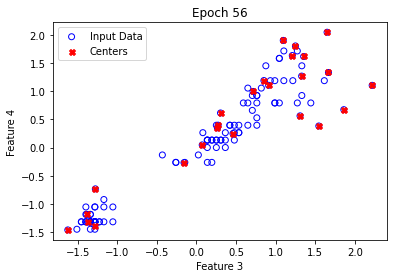

The amount of error in Epoch 57 is: 0.20755454473679552
The Number of New Centers in Epoch 57 is: 0
The Number of going through Gradient Descent in Epoch 57 is: 120
The number of centers in Epoch 57 is: 25
The Centers in Epoch 57 are as follows: 
[array([-1.13604543,  1.3083037 , -1.63041463, -1.46384859]), array([ 1.6149008 , -0.13185575,  0.30323887,  0.61541189]), array([ 0.08077791, -1.42363412,  0.0720911 ,  0.05012493]), array([1.67565109, 1.5318553 , 1.65478782, 2.04804846]), array([ 2.57255061, -0.9745928 ,  2.22678573,  1.10405423]), array([-1.35795978,  0.16289342, -1.36849852, -1.32152047]), array([-0.5639389 , -1.90356162,  1.21646706,  1.63210267]), array([-0.28013183,  0.13930915,  0.85464593,  1.19074432]), array([0.02403396, 1.12248834, 1.255789  , 1.80531434]), array([ 0.70111251, -0.98644543,  1.33200999,  1.26925834]), array([-0.17056542, -0.56231636,  1.10281668,  1.90224127]), array([-0.92763157,  0.98056152, -1.28060737, -0.73344367]), array([1.28969178, 0.3133675

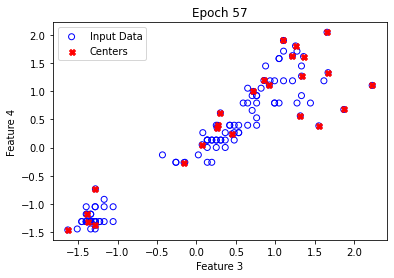

The amount of error in Epoch 58 is: 0.20777572966419033
The Number of New Centers in Epoch 58 is: 0
The Number of going through Gradient Descent in Epoch 58 is: 120
The number of centers in Epoch 58 is: 25
The Centers in Epoch 58 are as follows: 
[array([-1.13280391,  1.31580465, -1.63537315, -1.46871496]), array([ 1.61919634, -0.13420093,  0.30257392,  0.6175366 ]), array([ 0.08386394, -1.41759721,  0.0715794 ,  0.05288417]), array([1.67237927, 1.53248479, 1.65938412, 2.05255703]), array([ 2.57017072, -0.98010796,  2.2337924 ,  1.1056274 ]), array([-1.35322941,  0.15871207, -1.37005602, -1.32215609]), array([-0.56341155, -1.90596946,  1.22206827,  1.63298099]), array([-0.27949972,  0.13883066,  0.85721811,  1.19355409]), array([0.02193566, 1.12430463, 1.26108589, 1.80978467]), array([ 0.70146027, -0.9874668 ,  1.33542294,  1.27195326]), array([-0.17102726, -0.56328668,  1.10899723,  1.90571016]), array([-0.92341703,  0.9820467 , -1.28401589, -0.73585889]), array([1.28863354, 0.3117340

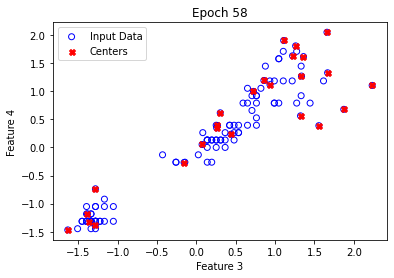

The amount of error in Epoch 59 is: 0.20801935223611642
The Number of New Centers in Epoch 59 is: 0
The Number of going through Gradient Descent in Epoch 59 is: 120
The number of centers in Epoch 59 is: 25
The Centers in Epoch 59 are as follows: 
[array([-1.1297778 ,  1.3232138 , -1.64039076, -1.47358224]), array([ 1.6233605 , -0.1364512 ,  0.30201811,  0.61945853]), array([ 0.08698377, -1.4115353 ,  0.07112606,  0.05547867]), array([1.66924898, 1.5329879 , 1.66390876, 2.05697129]), array([ 2.5679009 , -0.98538346,  2.24069518,  1.10731007]), array([-1.34858334,  0.15457124, -1.37175881, -1.32291787]), array([-0.56298201, -1.90836784,  1.22753704,  1.63385997]), array([-0.27884141,  0.13831533,  0.85977622,  1.19640206]), array([0.01995735, 1.12606835, 1.26630004, 1.81421234]), array([ 0.70185029, -0.98848753,  1.3388483 ,  1.27472666]), array([-0.17146134, -0.56424308,  1.11507797,  1.90918374]), array([-0.91930694,  0.98362749, -1.28763289, -0.73845304]), array([1.28765084, 0.3100569

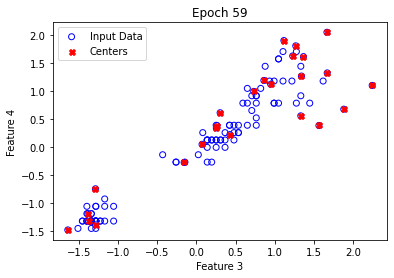

The amount of error in Epoch 60 is: 0.20828207407661647
The Number of New Centers in Epoch 60 is: 0
The Number of going through Gradient Descent in Epoch 60 is: 120
The number of centers in Epoch 60 is: 25
The Centers in Epoch 60 are as follows: 
[array([-1.12695444,  1.3305348 , -1.64546801, -1.4784525 ]), array([ 1.62739175, -0.13860705,  0.30157624,  0.62119243]), array([ 0.09011733, -1.40546074,  0.07072906,  0.05791381]), array([1.66625672, 1.53337084, 1.66836222, 2.06129698]), array([ 2.56573783, -0.99043584,  2.2474926 ,  1.10909529]), array([-1.34402277,  0.15047833, -1.37361235, -1.3238117 ]), array([-0.56263834, -1.91075804,  1.2328811 ,  1.63474482]), array([-0.27815641,  0.1377657 ,  0.86231959,  1.19928453]), array([0.01809285, 1.12777958, 1.27143134, 1.81859877]), array([ 0.70228273, -0.98950837,  1.34228376,  1.27757515]), array([-0.17186423, -0.56518878,  1.12106148,  1.91266261]), array([-0.91530625,  0.98530332, -1.29146017, -0.7412296 ]), array([1.28674095, 0.3083367

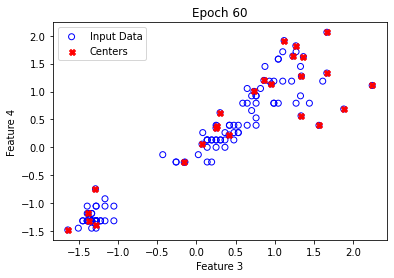

The amount of error in Epoch 61 is: 0.20856105473534853
The Number of New Centers in Epoch 61 is: 0
The Number of going through Gradient Descent in Epoch 61 is: 120
The number of centers in Epoch 61 is: 25
The Centers in Epoch 61 are as follows: 
[array([-1.12432255,  1.33777099, -1.65060497, -1.48332724]), array([ 1.63128976, -0.14067135,  0.30125124,  0.62275036]), array([ 0.09324832, -1.39938508,  0.07038643,  0.06019444]), array([1.66339886, 1.53363993, 1.67274497, 2.06553935]), array([ 2.56367862, -0.99527942,  2.25418417,  1.11097709]), array([-1.33954911,  0.1464406 , -1.37562196, -1.32484331]), array([-0.56237046, -1.91314096,  1.23810781,  1.63564053]), array([-0.27744483,  0.13718439,  0.86484772,  1.20219821]), array([0.0163365 , 1.12943905, 1.27647999, 1.82294552]), array([ 0.70275733, -0.99052968,  1.34572747,  1.28049594]), array([-0.17223344, -0.56612592,  1.12695048,  1.91614771]), array([-0.91141934,  0.98707343, -1.29549889, -0.74419155]), array([1.28590137, 0.3065746

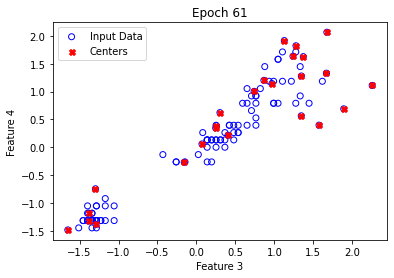

The amount of error in Epoch 62 is: 0.20885411900165896
The Number of New Centers in Epoch 62 is: 0
The Number of going through Gradient Descent in Epoch 62 is: 120
The number of centers in Epoch 62 is: 25
The Centers in Epoch 62 are as follows: 
[array([-1.12187216,  1.34492559, -1.65580142, -1.48820754]), array([ 1.63505526, -0.1426487 ,  0.30104438,  0.62414218]), array([ 0.09636363, -1.3933191 ,  0.07009624,  0.06232488]), array([1.66067179, 1.53380159, 1.6770576 , 2.06970324]), array([ 2.56172067, -0.99992669,  2.26077025,  1.11295038]), array([-1.33516389,  0.14246523, -1.37779277, -1.3260183 ]), array([-0.56216978, -1.91551729,  1.24322422,  1.6365519 ]), array([-0.27670717,  0.13657409,  0.86736022,  1.2051401 ]), array([0.01468314, 1.131048  , 1.28144663, 1.82725426]), array([ 0.70327358, -0.99155159,  1.34917807,  1.28348675]), array([-0.17256726, -0.56705594,  1.13274787,  1.91964024]), array([-0.90765007,  0.98893687, -1.29974959, -0.74734139]), array([1.28512986, 0.3047722

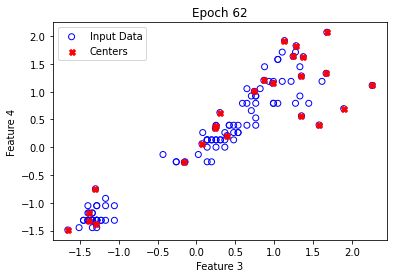

The amount of error in Epoch 63 is: 0.2085245689103196
The Number of New Centers in Epoch 63 is: 1
The Number of going through Gradient Descent in Epoch 63 is: 119
The number of centers in Epoch 63 is: 26
The Centers in Epoch 63 are as follows: 
[array([-1.1207555 ,  1.35074118, -1.66124074, -1.49271788]), array([ 1.64502562, -0.141419  ,  0.30668623,  0.62558216]), array([ 0.10370204, -1.38528089,  0.0724242 ,  0.06484082]), array([1.65611599, 1.53596146, 1.68137471, 2.07680339]), array([ 2.55995178, -1.00814133,  2.26861088,  1.11586312]), array([-1.33090594,  0.13859544, -1.38008011, -1.32728059]), array([-0.56336127, -1.91829521,  1.24743344,  1.63746345]), array([-0.27711487,  0.13567182,  0.86935771,  1.20827466]), array([0.01005103, 1.13273631, 1.28544358, 1.83263042]), array([ 0.70222048, -0.99357533,  1.35208214,  1.28683717]), array([-0.17500934, -0.56858609,  1.13754193,  1.92355692]), array([-0.90407598,  0.99063463, -1.30413406, -0.7506988 ]), array([1.28246447, 0.30269477

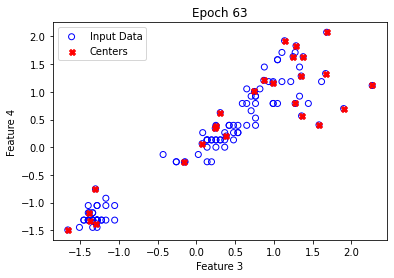

The amount of error in Epoch 64 is: 0.20436384264217536
The Number of New Centers in Epoch 64 is: 0
The Number of going through Gradient Descent in Epoch 64 is: 120
The number of centers in Epoch 64 is: 26
The Centers in Epoch 64 are as follows: 
[array([-1.11884775,  1.35766777, -1.66647872, -1.49686294]), array([ 1.65252519, -0.14165858,  0.30947458,  0.62464388]), array([ 0.10847729, -1.37849351,  0.073093  ,  0.06560802]), array([1.65152368, 1.53711487, 1.685197  , 2.08298736]), array([ 2.55748581, -1.01494231,  2.27543794,  1.11886159]), array([-1.32680256,  0.13475336, -1.3826165 , -1.32876292]), array([-0.56357709, -1.92033334,  1.25192598,  1.6386745 ]), array([-0.276841  ,  0.13494072,  0.87157453,  1.21157742]), array([0.00670929, 1.13410667, 1.28948061, 1.83773642]), array([ 0.70169628, -0.9950408 ,  1.35501205,  1.29024665]), array([-0.17630168, -0.56948144,  1.14249853,  1.92736815]), array([-0.90047947,  0.9926393 , -1.30870908, -0.75402273]), array([1.27995954, 0.3006172

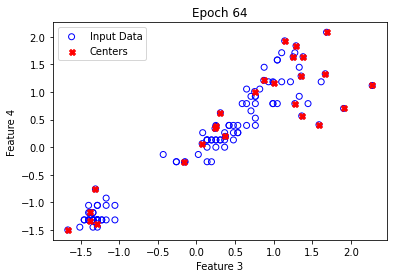

The amount of error in Epoch 65 is: 0.20436118827271738
The Number of New Centers in Epoch 65 is: 0
The Number of going through Gradient Descent in Epoch 65 is: 120
The number of centers in Epoch 65 is: 26
The Centers in Epoch 65 are as follows: 
[array([-1.11687642,  1.36489694, -1.67180139, -1.50106194]), array([ 1.65911101, -0.14270409,  0.31206245,  0.62361671]), array([ 0.11267706, -1.3721593 ,  0.0737667 ,  0.06634109]), array([1.64717992, 1.53819241, 1.68894204, 2.08895316]), array([ 2.5552516 , -1.02125345,  2.28213584,  1.12190952]), array([-1.3227667 ,  0.13108875, -1.38534383, -1.33041874]), array([-0.56366874, -1.92233072,  1.25645765,  1.64001177]), array([-0.2764318 ,  0.1343143 ,  0.87380529,  1.21489583]), array([0.00373958, 1.13565084, 1.2934909 , 1.84277919]), array([ 0.70138683, -0.99642314,  1.35801113,  1.2937146 ]), array([-0.17733635, -0.5701716 ,  1.14746852,  1.93126725]), array([-0.89696912,  0.99481142, -1.31349053, -0.7575646 ]), array([1.27765015, 0.2986099

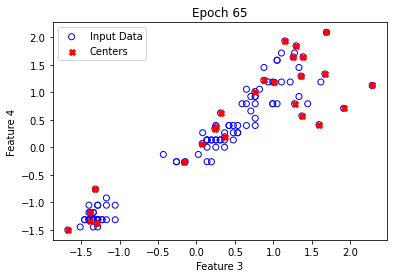

The amount of error in Epoch 66 is: 0.20438718405429063
The Number of New Centers in Epoch 66 is: 0
The Number of going through Gradient Descent in Epoch 66 is: 120
The number of centers in Epoch 66 is: 26
The Centers in Epoch 66 are as follows: 
[array([-1.11495198,  1.372095  , -1.67713859, -1.50525349]), array([ 1.66547712, -0.14383232,  0.31476865,  0.6227402 ]), array([ 0.1167719 , -1.36589558,  0.07454581,  0.06713933]), array([1.64299601, 1.53935412, 1.69266069, 2.09484331]), array([ 2.55317733, -1.02740008,  2.28878575,  1.12493735]), array([-1.31880069,  0.12754314, -1.38823907, -1.33222764]), array([-0.56379057, -1.92436106,  1.26090242,  1.64132358]), array([-0.27601159,  0.13368968,  0.87600728,  1.21818901]), array([8.52346487e-04, 1.13728128e+00, 1.29742274e+00, 1.84775261e+00]), array([ 0.70110102, -0.99785478,  1.36100965,  1.2971806 ]), array([-0.17836274, -0.57084012,  1.15234976,  1.93514733]), array([-0.89354588,  0.99709116, -1.3184509 , -0.76128146]), array([1.275

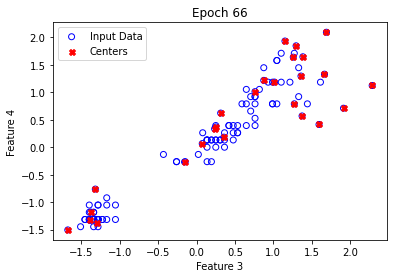

The amount of error in Epoch 67 is: 0.20441617103251514
The Number of New Centers in Epoch 67 is: 0
The Number of going through Gradient Descent in Epoch 67 is: 120
The number of centers in Epoch 67 is: 26
The Centers in Epoch 67 are as follows: 
[array([-1.11311221,  1.37919282, -1.68245896, -1.50940191]), array([ 1.6719088 , -0.14480353,  0.31762561,  0.62200659]), array([ 0.12094425, -1.35956434,  0.07540902,  0.0679776 ]), array([1.63890005, 1.54066959, 1.696381  , 2.10072455]), array([ 2.55119762, -1.03351831,  2.29543532,  1.12793103]), array([-1.31490394,  0.12409811, -1.3912931 , -1.33418125]), array([-0.56399778, -1.92643421,  1.26523219,  1.64257063]), array([-0.27563237,  0.1330339 ,  0.87817259,  1.22145117]), array([-0.00208093,  1.13895672,  1.3012678 ,  1.85266522]), array([ 0.70074361, -0.99938371,  1.36398438,  1.3006278 ]), array([-0.17948944, -0.57154988,  1.15711557,  1.93897291]), array([-0.8902025 ,  0.99946214, -1.32357112, -0.76514293]), array([1.27311195, 0.294

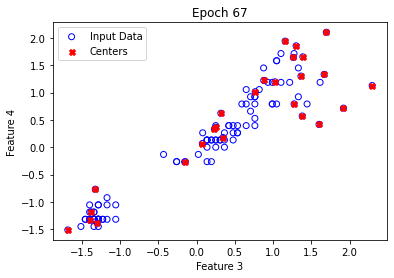

The amount of error in Epoch 68 is: 0.20444671513474175
The Number of New Centers in Epoch 68 is: 0
The Number of going through Gradient Descent in Epoch 68 is: 120
The number of centers in Epoch 68 is: 26
The Centers in Epoch 68 are as follows: 
[array([-1.11136667,  1.38620309, -1.6877419 , -1.51348576]), array([ 1.67854956, -0.14556248,  0.32059477,  0.62137781]), array([ 0.12527187, -1.35313264,  0.07631511,  0.06882154]), array([1.6348441 , 1.54217315, 1.70012484, 2.10662924]), array([ 2.54926392, -1.03966959,  2.30211731,  1.1308906 ]), array([-1.31107147,  0.12075802, -1.39450068, -1.3362749 ]), array([-0.56430685, -1.92854241,  1.26945123,  1.64374719]), array([-0.27531871,  0.13233862,  0.88030253,  1.22468295]), array([-0.00512277,  1.14065927,  1.30503063,  1.85752241]), array([ 0.70026405, -1.00102993,  1.36693064,  1.30405134]), array([-0.18076695, -0.57232211,  1.16176599,  1.94273149]), array([-0.88693053,  1.00192394, -1.32883595, -0.76913175]), array([1.27074715, 0.292

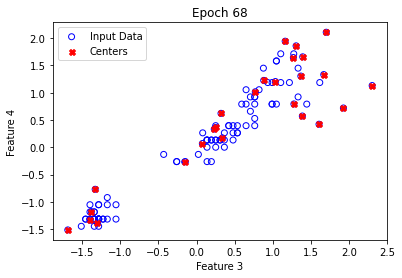

The amount of error in Epoch 69 is: 0.2044929851101121
The Number of New Centers in Epoch 69 is: 0
The Number of going through Gradient Descent in Epoch 69 is: 120
The number of centers in Epoch 69 is: 26
The Centers in Epoch 69 are as follows: 
[array([-1.10971286,  1.39316561, -1.69297628, -1.51749725]), array([ 1.68544498, -0.14611948,  0.32359918,  0.62081164]), array([ 0.12976819, -1.34660728,  0.07721418,  0.06964013]), array([1.63080702, 1.54387183, 1.70391176, 2.11256691]), array([ 2.54734386, -1.04587315,  2.30885037,  1.13381979]), array([-1.30729661,  0.11753571, -1.3978581 , -1.33850546]), array([-0.56470987, -1.93067456,  1.27357839,  1.64485984]), array([-0.27507886,  0.13160387,  0.882403  ,  1.22788652]), array([-0.00829229,  1.14238036,  1.30872476,  1.86232696]), array([ 0.69964268, -1.00280129,  1.36985377,  1.3074501 ]), array([-0.18220758, -0.57316259,  1.16631519,  1.94642029]), array([-0.88372214,  1.00448186, -1.33423297, -0.77323763]), array([1.26828087, 0.2906

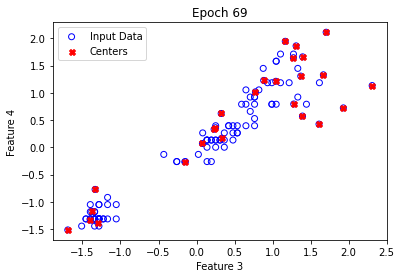

The amount of error in Epoch 70 is: 0.2045737974619206
The Number of New Centers in Epoch 70 is: 0
The Number of going through Gradient Descent in Epoch 70 is: 120
The number of centers in Epoch 70 is: 26
The Centers in Epoch 70 are as follows: 
[array([-1.10814343,  1.40012783, -1.69816196, -1.52144254]), array([ 1.69256153, -0.14650916,  0.32654275,  0.62026765]), array([ 0.13440078, -1.34001094,  0.07805522,  0.07040869]), array([1.62679381, 1.54574936, 1.70775872, 2.11853077]), array([ 2.5454231 , -1.05211911,  2.31564018,  1.13672394]), array([-1.30357259,  0.11444666, -1.40136251, -1.34087094]), array([-0.56518241, -1.93282162,  1.27763983,  1.64592158]), array([-0.27490965,  0.13083273,  0.88448221,  1.23106449]), array([-0.01157547,  1.14411586,  1.31237015,  1.86708114]), array([ 0.69888469, -1.00469805,  1.3727654 ,  1.31082529]), array([-0.18379459, -0.57407031,  1.17078591,  1.95004342]), array([-0.88057163,  1.00714288, -1.33975308, -0.77745546]), array([1.26571882, 0.2887

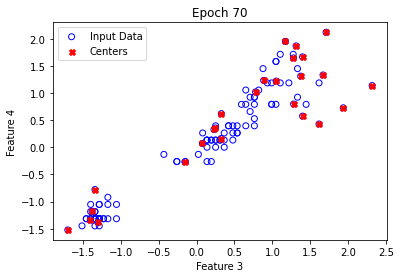

The amount of error in Epoch 71 is: 0.20470129750787833
The Number of New Centers in Epoch 71 is: 0
The Number of going through Gradient Descent in Epoch 71 is: 120
The number of centers in Epoch 71 is: 26
The Centers in Epoch 71 are as follows: 
[array([-1.10665055,  1.40713289, -1.70330873, -1.52533912]), array([ 1.69981297, -0.14677115,  0.32933317,  0.61971336]), array([ 0.13911122, -1.33337027,  0.07879599,  0.07111199]), array([1.62282976, 1.54777295, 1.71167865, 2.12450442]), array([ 2.54350496, -1.05837979,  2.32248197,  1.13960922]), array([-1.29989351,  0.11150593, -1.40501163, -1.34337008]), array([-0.5656924 , -1.93497917,  1.28166298,  1.64694842]), array([-0.27480127,  0.1300291 ,  0.88654841,  1.23421937]), array([-0.01493684,  1.145864  ,  1.31598904,  1.87178792]), array([ 0.69801274, -1.0067158 ,  1.37567998,  1.31417998]), array([-0.18549283, -0.5750415 ,  1.17520397,  1.95361025]), array([-0.87747635,  1.00991312, -1.34539061, -0.78178473]), array([1.26308686, 0.286

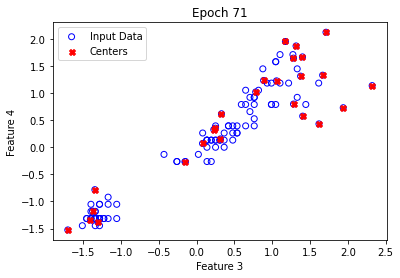

The amount of error in Epoch 72 is: 0.20488085704582532
The Number of New Centers in Epoch 72 is: 0
The Number of going through Gradient Descent in Epoch 72 is: 120
The number of centers in Epoch 72 is: 26
The Centers in Epoch 72 are as follows: 
[array([-1.10522689,  1.41421459, -1.70843311, -1.52921077]), array([ 1.70708501, -0.14694224,  0.33189106,  0.61912079]), array([ 0.14382794, -1.3267121 ,  0.07940463,  0.07174019]), array([1.61895143, 1.54989775, 1.71567827, 2.130466  ]), array([ 2.54160454, -1.06461655,  2.3293617 ,  1.14248289]), array([-1.29625514,  0.10872623, -1.40880376, -1.3460024 ]), array([-0.56620495, -1.93714565,  1.28567313,  1.64795763]), array([-0.27473998,  0.12919683,  0.8886089 ,  1.23735378]), array([-0.018328  ,  1.14762295,  1.31960265,  1.87645131]), array([ 0.69706036, -1.00884596,  1.37861219,  1.31751931]), array([-0.18725593, -0.57607029,  1.1795947 ,  1.95713372]), array([-0.8744369 ,  1.01279702, -1.35114328, -0.78622841]), array([1.260423  , 0.284

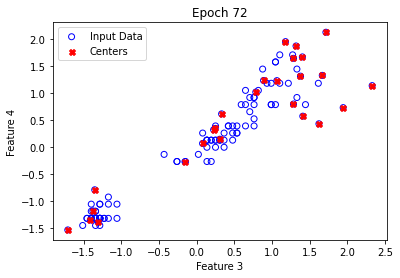

The amount of error in Epoch 73 is: 0.2051102058387335
The Number of New Centers in Epoch 73 is: 0
The Number of going through Gradient Descent in Epoch 73 is: 120
The number of centers in Epoch 73 is: 26
The Centers in Epoch 73 are as follows: 
[array([-1.10386638,  1.42139434, -1.71355568, -1.53308373]), array([ 1.71425549, -0.14705311,  0.33416028,  0.6184676 ]), array([ 0.14847829, -1.32006023,  0.07986312,  0.07228869]), array([1.61519943, 1.55207388, 1.71975733, 2.13639239]), array([ 2.53974509, -1.07078668,  2.33625881,  1.14535288]), array([-1.29265536,  0.10611682, -1.4127379 , -1.34876813]), array([-0.56668759, -1.93932221,  1.28969059,  1.6489663 ]), array([-0.27471068,  0.12833955,  0.89066919,  1.24047042]), array([-0.02169595,  1.1493909 ,  1.32322848,  1.88107645]), array([ 0.69606588, -1.01107702,  1.38157489,  1.32085011]), array([-0.1890339 , -0.57714936,  1.18397985,  1.9606291 ]), array([-0.87145683,  1.01579662, -1.35701182, -0.79079203]), array([1.25777049, 0.2826

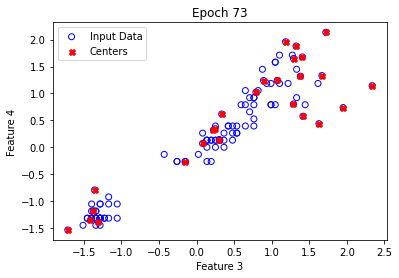

The amount of error in Epoch 74 is: 0.2053834713791177
The Number of New Centers in Epoch 74 is: 0
The Number of going through Gradient Descent in Epoch 74 is: 120
The number of centers in Epoch 74 is: 26
The Centers in Epoch 74 are as follows: 
[array([-1.10256446,  1.42867966, -1.71869764, -1.53698257]), array([ 1.72121386, -0.14712516,  0.33611302,  0.61773863]), array([ 0.1529994 , -1.31343282,  0.0801682 ,  0.07275765]), array([1.61161181, 1.5542532 , 1.72390912, 2.1422625 ]), array([ 2.53795307, -1.07684991,  2.34314934,  1.14822686]), array([-1.28909414,  0.10368295, -1.41681347, -1.35166799]), array([-0.56711428, -1.94151209,  1.29372877,  1.64998934]), array([-0.27469941,  0.12746025,  0.89273233,  1.24357163]), array([-0.02499092,  1.15116578,  1.32687842,  1.88566901]), array([ 0.69506641, -1.01339626,  1.38457745,  1.32417993]), array([-0.19078025, -0.57827106,  1.18837529,  1.96411182]), array([-0.86854187,  1.01891129, -1.36299902, -0.79548234]), array([1.2551711 , 0.2806

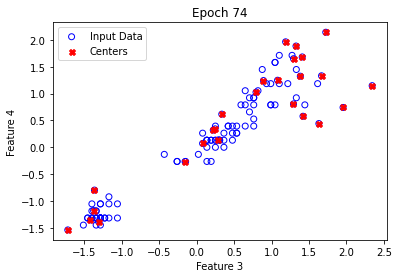

The amount of error in Epoch 75 is: 0.20569423954579988
The Number of New Centers in Epoch 75 is: 0
The Number of going through Gradient Descent in Epoch 75 is: 120
The number of centers in Epoch 75 is: 26
The Centers in Epoch 75 are as follows: 
[array([-1.10131828,  1.43606609, -1.72387856, -1.54092787]), array([ 1.72787239, -0.14717043,  0.33774811,  0.61692499]), array([ 0.15734383, -1.30684143,  0.08032898,  0.07315043]), array([1.60821984, 1.55639412, 1.72812201, 2.14805949]), array([ 2.53625428, -1.0827726 ,  2.350009  ,  1.15111187]), array([-1.28557316,  0.10142606, -1.42103016, -1.35470285]), array([-0.56746729, -1.94372009,  1.29779417,  1.65103871]), array([-0.27469455,  0.12656124,  0.89479898,  1.24665911]), array([-0.02817119,  1.1529455 ,  1.33055859,  1.89023478]), array([ 0.6940939 , -1.01579098,  1.38762515,  1.32751625]), array([-0.19245634, -0.57942824,  1.19279049,  1.96759611]), array([-0.86569895,  1.02213812, -1.36910872, -0.80030608]), array([1.25266062, 0.278

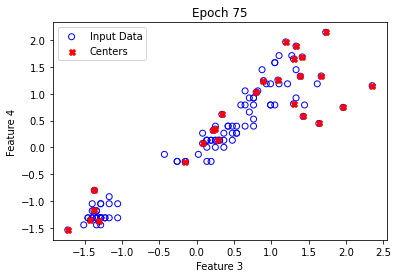

The amount of error in Epoch 76 is: 0.20603650601735435
The Number of New Centers in Epoch 76 is: 0
The Number of going through Gradient Descent in Epoch 76 is: 120
The number of centers in Epoch 76 is: 26
The Centers in Epoch 76 are as follows: 
[array([-1.10012605,  1.44353979, -1.72911403, -1.54493417]), array([ 1.73417037, -0.14719365,  0.33908492,  0.61602214]), array([ 0.16148092, -1.30029194,  0.08036311,  0.07347165]), array([1.60504572, 1.55846332, 1.7323808 , 2.15377086]), array([ 2.5346702 , -1.08852883,  2.35681461,  1.154014  ]), array([-1.28209548,  0.09934441, -1.42538786, -1.35787372]), array([-0.56773686, -1.94595109,  1.30188712,  1.652123  ]), array([-0.27468739,  0.12564434,  0.89686796,  1.24973412]), array([-0.03120492,  1.1547276 ,  1.33426966,  1.89477892]), array([ 0.69317327, -1.01824923,  1.39071956,  1.3308661 ]), array([-0.19403301, -0.58061439,  1.19722893,  1.97109375]), array([-0.86293533,  1.02547257, -1.37534504, -0.80526912]), array([1.25026683, 0.276

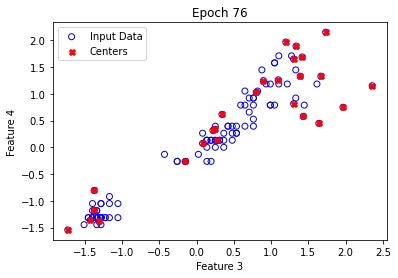

The amount of error in Epoch 77 is: 0.206404630475152
The Number of New Centers in Epoch 77 is: 0
The Number of going through Gradient Descent in Epoch 77 is: 120
The number of centers in Epoch 77 is: 26
The Centers in Epoch 77 are as follows: 
[array([-1.09898679,  1.45108186, -1.73441543, -1.54901004]), array([ 1.74007257, -0.14719458,  0.34015653,  0.61502774]), array([ 0.16539522, -1.29378555,  0.08029277,  0.07372553]), array([1.60210233, 1.56043673, 1.73666856, 2.15938862]), array([ 2.53321678, -1.09410097,  2.36354579,  1.15693834]), array([-1.27866514,  0.09743415, -1.42988665, -1.36118162]), array([-0.56792043, -1.94820972,  1.30600348,  1.65324795]), array([-0.27467193,  0.1247111 ,  0.89893688,  1.25279746]), array([-0.03407056,  1.15650953,  1.33800822,  1.89930577]), array([ 0.69232214, -1.02076019,  1.3938593 ,  1.33423577]), array([-0.19549085, -0.58182384,  1.20168937,  1.97461391]), array([-0.86025785,  1.02890939, -1.38171169, -0.81037586]), array([1.24800897, 0.27431

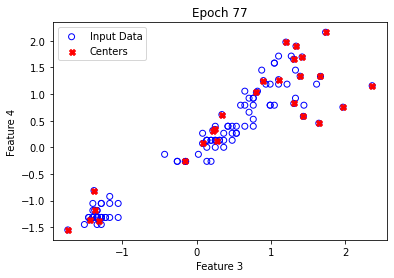

The amount of error in Epoch 78 is: 0.2067940144423333
The Number of New Centers in Epoch 78 is: 0
The Number of going through Gradient Descent in Epoch 78 is: 120
The number of centers in Epoch 78 is: 26
The Centers in Epoch 78 are as follows: 
[array([-1.09790014,  1.45867207, -1.73979006, -1.55315877]), array([ 1.74556519, -0.14717089,  0.34100344,  0.61394016]), array([ 0.16908361, -1.28732062,  0.08014147,  0.07391481]), array([1.59939405, 1.56229891, 1.740968  , 2.16490886]), array([ 2.53190424, -1.09947898,  2.37018585,  1.15988921]), array([-1.27528668,  0.09569045, -1.4345268 , -1.3646276 ]), array([-0.56802112, -1.95049991,  1.3101364 ,  1.65441727]), array([-0.27464444,  0.12376301,  0.90100272,  1.25584965]), array([-0.03675596,  1.15828894,  1.34176797,  1.90381896]), array([ 0.69155146, -1.02331425,  1.39704094,  1.33763078]), array([-0.19681918, -0.58305169,  1.20616729,  1.97816342]), array([-0.85767253,  1.03244346, -1.3882116 , -0.81562912]), array([1.24589853, 0.2721

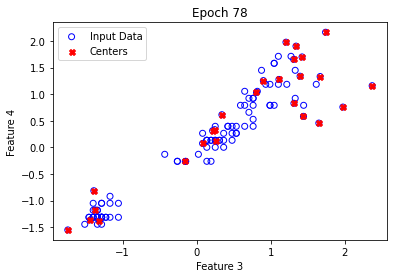

The amount of error in Epoch 79 is: 0.20720155585355965
The Number of New Centers in Epoch 79 is: 0
The Number of going through Gradient Descent in Epoch 79 is: 120
The number of centers in Epoch 79 is: 26
The Centers in Epoch 79 are as follows: 
[array([-1.09686623,  1.46629069, -1.74524146, -1.55737916]), array([ 1.75065128, -0.14711968,  0.34166886,  0.6127579 ]), array([ 0.17255232, -1.28089415,  0.07993191,  0.07404059]), array([1.59691815, 1.56404167, 1.74526244, 2.17033085]), array([ 2.5307373 , -1.10465918,  2.37672174,  1.16287008]), array([-1.27196494,  0.09410815, -1.43930867, -1.36821264]), array([-0.56804607, -1.95282453,  1.31427762,  1.65563312]), array([-0.27460306,  0.12280161,  0.90306222,  1.25889092]), array([-0.03925683,  1.16006358,  1.34554081,  1.90832115]), array([ 0.69086662, -1.02590296,  1.40025977,  1.34105582]), array([-0.19801452, -0.58429369,  1.21065608,  1.98174691]), array([-0.85518433,  1.0360701 , -1.39484671, -0.82103006]), array([1.24394046, 0.269

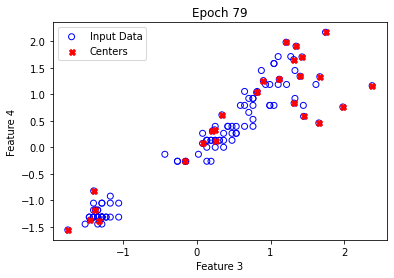

The amount of error in Epoch 80 is: 0.20762554651800208
The Number of New Centers in Epoch 80 is: 0
The Number of going through Gradient Descent in Epoch 80 is: 120
The number of centers in Epoch 80 is: 26
The Centers in Epoch 80 are as follows: 
[array([-1.0958854 ,  1.4739194 , -1.75076976, -1.56166645]), array([ 1.75534675, -0.14703768,  0.34219539,  0.61147951]), array([ 0.17581414, -1.2745025 ,  0.0796847 ,  0.07410245]), array([1.59466642, 1.56566221, 1.74953624, 2.17565601]), array([ 2.52971582, -1.10964255,  2.38314358,  1.16588364]), array([-1.26870489,  0.09268197, -1.44423258, -1.37193759]), array([-0.56800486, -1.95518514,  1.31841843,  1.65689647]), array([-0.2745473 ,  0.12182837,  0.90511214,  1.26192117]), array([-0.04157483,  1.16183115,  1.34931766,  1.91281398]), array([ 0.69026866, -1.02851904,  1.40351027,  1.34451464]), array([-0.19907868, -0.58554614,  1.21514798,  1.98536695]), array([-0.85279722,  1.03978496, -1.40161778, -0.82657837]), array([1.2421347 , 0.267

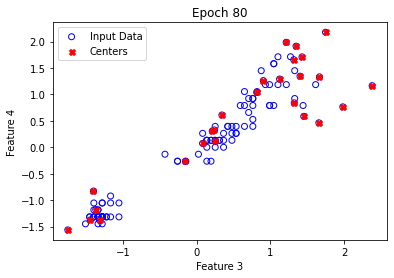

The amount of error in Epoch 81 is: 0.20806521258832028
The Number of New Centers in Epoch 81 is: 0
The Number of going through Gradient Descent in Epoch 81 is: 120
The number of centers in Epoch 81 is: 26
The Centers in Epoch 81 are as follows: 
[array([-1.09495823,  1.48154232, -1.75637262, -1.56601349]), array([ 1.75967597, -0.14692228,  0.34262298,  0.61010368]), array([ 0.17888599, -1.26814231,  0.07941787,  0.07409884]), array([1.59262692, 1.56716174, 1.7537753 , 2.18088724]), array([ 2.52883616, -1.11443341,  2.38944444,  1.16893201]), array([-1.26551143,  0.09140694, -1.44929878, -1.37580309]), array([-0.5679083 , -1.95758211,  1.32255049,  1.65820764]), array([-0.27447764,  0.12084471,  0.90714937,  1.26493996]), array([-0.04371592,  1.16358955,  1.35308925,  1.91729832]), array([ 0.68975546, -1.03115624,  1.40678668,  1.34801009]), array([-0.20001722, -0.58680566,  1.21963499,  1.9890247 ]), array([-0.8505142 ,  1.04358419, -1.40852447, -0.83227242]), array([1.24047759, 0.265

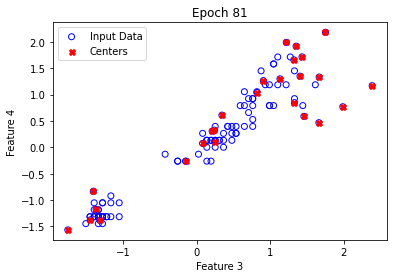

The amount of error in Epoch 82 is: 0.2085204378260999
The Number of New Centers in Epoch 82 is: 0
The Number of going through Gradient Descent in Epoch 82 is: 120
The number of centers in Epoch 82 is: 26
The Centers in Epoch 82 are as follows: 
[array([-1.09408552,  1.48914649, -1.76204598, -1.5704118 ]), array([ 1.76366757, -0.14677311,  0.34298729,  0.60862902]), array([ 0.18178633, -1.26181168,  0.07914643,  0.07402737]), array([1.59078547, 1.56854426, 1.75796731, 2.18602843]), array([ 2.52809216, -1.11903832,  2.39562   ,  1.17201685]), array([-1.26238934,  0.09027899, -1.45450749, -1.37980973]), array([-0.56776758, -1.96001488,  1.32666638,  1.65956668]), array([-0.27439502,  0.1198523 ,  0.90917122,  1.26794673]), array([-0.04568883,  1.16533702,  1.35684669,  1.92177444]), array([ 0.68932321, -1.03380893,  1.41008351,  1.35154445]), array([-0.20083801, -0.58806912,  1.22410949,  1.99272035]), array([-0.84833742,  1.04746481, -1.41556548, -0.83810978]), array([1.23896332, 0.2634

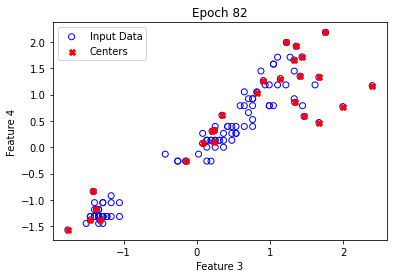

The amount of error in Epoch 83 is: 0.20899099023422021
The Number of New Centers in Epoch 83 is: 0
The Number of going through Gradient Descent in Epoch 83 is: 120
The number of centers in Epoch 83 is: 26
The Centers in Epoch 83 are as follows: 
[array([-1.09326865,  1.4967219 , -1.76778505, -1.57485264]), array([ 1.76735146, -0.14659148,  0.34331904,  0.6070541 ]), array([ 0.18453395, -1.25550967,  0.07888245,  0.07388511]), array([1.58912696, 1.56981579, 1.76210202, 2.1910843 ]), array([ 2.52747627, -1.12346561,  2.40166838,  1.17513951]), array([-1.25934331,  0.08929502, -1.45985895, -1.38395803]), array([-0.56759376, -1.96248245,  1.33075991,  1.66097356]), array([-0.27430057,  0.11885298,  0.91117545,  1.27094082]), array([-0.04750412,  1.16707217,  1.36058196,  1.92624239]), array([ 0.68896706, -1.03647222,  1.41339595,  1.35511958]), array([-0.20155038, -0.58933389,  1.22856473,  1.99645359]), array([-0.8462684 ,  1.05142467, -1.42273874, -0.84408741]), array([1.23758487, 0.261

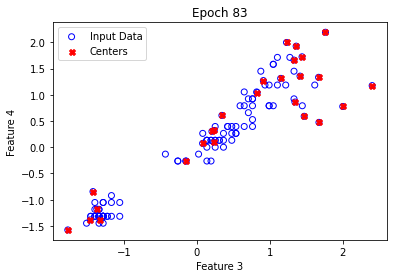

The amount of error in Epoch 84 is: 0.2094768673183464
The Number of New Centers in Epoch 84 is: 0
The Number of going through Gradient Descent in Epoch 84 is: 120
The number of centers in Epoch 84 is: 26
The Centers in Epoch 84 are as follows: 
[array([-1.09250916,  1.50426119, -1.77358458, -1.57932744]), array([ 1.77075737, -0.14637864,  0.34364403,  0.60537776]), array([ 0.18714711, -1.2492354 ,  0.07863509,  0.07366895]), array([1.58763618, 1.57098334, 1.76617107, 2.19605986]), array([ 2.52698009, -1.12772465,  2.40758937,  1.17830088]), array([-1.25637778,  0.08845236, -1.46535316, -1.38824827]), array([-0.56739714, -1.96498363,  1.33482614,  1.66242816]), array([-0.27419568,  0.11784845,  0.91316019,  1.27392135]), array([-0.04917316,  1.1687938 ,  1.36428805,  1.93070202]), array([ 0.68868158, -1.03914207,  1.41671964,  1.35873672]), array([-0.20216419, -0.59059791,  1.23299487,  2.00022365]), array([-0.84430799,  1.0554623 , -1.43004142, -0.85020156]), array([1.23633463, 0.2590

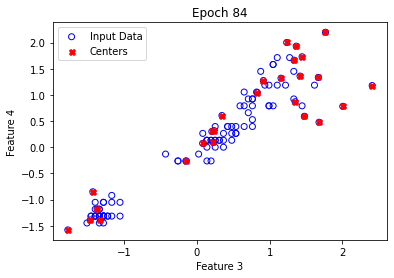

The amount of error in Epoch 85 is: 0.20997833223119738
The Number of New Centers in Epoch 85 is: 0
The Number of going through Gradient Descent in Epoch 85 is: 120
The number of centers in Epoch 85 is: 26
The Centers in Epoch 85 are as follows: 
[array([-1.09180843,  1.51175942, -1.77943896, -1.5838279 ]), array([ 1.77391313, -0.14613655,  0.34398304,  0.60359895]), array([ 0.1896423 , -1.24298874,  0.07841075,  0.0733755 ]), array([1.58629832, 1.57205416, 1.77016762, 2.20095998]), array([ 2.52659466, -1.13182515,  2.41338387,  1.18150138]), array([-1.25349702,  0.08774899, -1.47098999, -1.39268059]), array([-0.56718688, -1.96751683,  1.33886128,  1.66393028]), array([-0.2740816 ,  0.11684034,  0.91512394,  1.27688738]), array([-0.0507074 ,  1.17050076,  1.36795892,  1.93515288]), array([ 0.68846131, -1.04181495,  1.42005076,  1.36239659]), array([-0.20268914, -0.59185949,  1.23739504,  2.00402933]), array([-0.84245648,  1.05957701, -1.43747012, -0.856448  ]), array([1.23520486, 0.256

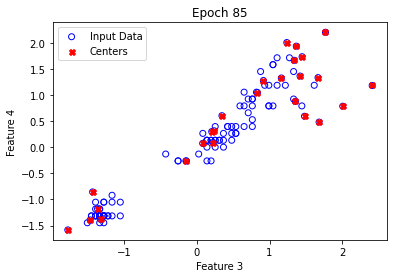

The amount of error in Epoch 86 is: 0.21049572652810594
The Number of New Centers in Epoch 86 is: 0
The Number of going through Gradient Descent in Epoch 86 is: 120
The number of centers in Epoch 86 is: 26
The Centers in Epoch 86 are as follows: 
[array([-1.09116768,  1.51921388, -1.78534258, -1.58834631]), array([ 1.77684301, -0.14586856,  0.34435183,  0.60171618]), array([ 0.19203328, -1.23677071,  0.07821322,  0.07300106]), array([1.58509933, 1.57303539, 1.77408619, 2.20578918]), array([ 2.52631104, -1.1357766 ,  2.41905357,  1.18474102]), array([-1.25070525,  0.08718344, -1.47676929, -1.39725505]), array([-0.56697077, -1.97008019,  1.34286276,  1.66547987]), array([-0.2739593 ,  0.11583044,  0.91706566,  1.27983796]), array([-0.05211777,  1.17219214,  1.37158956,  1.93959442]), array([ 0.68830133, -1.04448752,  1.42338624,  1.36609967]), array([-0.20313418, -0.59311703,  1.24176134,  2.0078693 ]), array([-0.84071378,  1.06376874, -1.44502101, -0.86282208]), array([1.23418822, 0.254

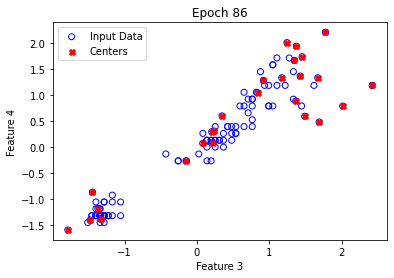

The amount of error in Epoch 87 is: 0.21102933791593995
The Number of New Centers in Epoch 87 is: 0
The Number of going through Gradient Descent in Epoch 87 is: 120
The number of centers in Epoch 87 is: 26
The Centers in Epoch 87 are as follows: 
[array([-1.09058783,  1.52662319, -1.79128971, -1.59287542]), array([ 1.77956826, -0.14557861,  0.34476221,  0.59972819]), array([ 0.19433142, -1.23058335,  0.07804427,  0.07254195]), array([1.58402608, 1.5739339 , 1.77792236, 2.21055147]), array([ 2.52612047, -1.13958822,  2.42460055,  1.18801926]), array([-1.24800653,  0.08675467, -1.48269074, -1.40197158]), array([-0.56675531, -1.97267155,  1.34682888,  1.66707675]), array([-0.2738295 ,  0.11482049,  0.91898464,  1.28277211]), array([-0.05341459,  1.17386705,  1.37517576,  1.94402577]), array([ 0.68819718, -1.04715661,  1.42672343,  1.36984604]), array([-0.20350751, -0.59436905,  1.24609063,  2.01174189]), array([-0.83907943,  1.06803775, -1.45268977, -0.86931876]), array([1.23327764, 0.252

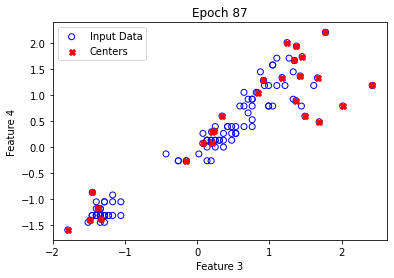

The amount of error in Epoch 88 is: 0.21157884180202327
The Number of New Centers in Epoch 88 is: 0
The Number of going through Gradient Descent in Epoch 88 is: 120
The number of centers in Epoch 88 is: 26
The Centers in Epoch 88 are as follows: 
[array([-1.09006961,  1.53398711, -1.79727476, -1.5974087 ]), array([ 1.78210735, -0.14527108,  0.34522306,  0.59763442]), array([ 0.19654612, -1.22442933,  0.07790433,  0.07199495]), array([1.58306658, 1.57475623, 1.78167273, 2.21525048]), array([ 2.5260147 , -1.14326889,  2.43002732,  1.19133512]), array([-1.24540474,  0.08646204, -1.48875383, -1.40682989]), array([-0.56654595, -1.97528875,  1.35075868,  1.66872069]), array([-0.27369275,  0.11381218,  0.92088036,  1.28568878]), array([-0.05460752,  1.17552481,  1.37871407,  1.94844593]), array([ 0.68814487, -1.04981934,  1.43006014,  1.37363543]), array([-0.2038166 , -0.59561431,  1.25038045,  2.01564534]), array([-0.83755271,  1.07238471, -1.46047175, -0.87593278]), array([1.2324665 , 0.250

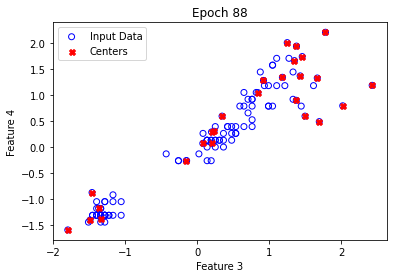

The amount of error in Epoch 89 is: 0.21214221489195945
The Number of New Centers in Epoch 89 is: 0
The Number of going through Gradient Descent in Epoch 89 is: 120
The number of centers in Epoch 89 is: 26
The Centers in Epoch 89 are as follows: 
[array([-1.08961368,  1.54130588, -1.80329221, -1.60194024]), array([ 1.78447686, -0.14495017,  0.34574111,  0.59543536]), array([ 0.19868539, -1.21831171,  0.07779294,  0.07135754]), array([1.58220994, 1.57550849, 1.78533477, 2.21988936]), array([ 2.52598596, -1.14682711,  2.43533657,  1.19468719]), array([-1.24290353,  0.08630513, -1.4949577 , -1.41182939]), array([-0.56634712, -1.9779296 ,  1.35465169,  1.67041123]), array([-0.27354957,  0.11280703,  0.92275247,  1.28858684]), array([-0.0557056 ,  1.17716478,  1.38220164,  1.95285372]), array([ 0.68814078, -1.05247319,  1.43339447,  1.37746725]), array([-0.20406819, -0.59685182,  1.25462887,  2.01957764]), array([-0.8361327 ,  1.07681048, -1.46836196, -0.88265871]), array([1.23174859, 0.248

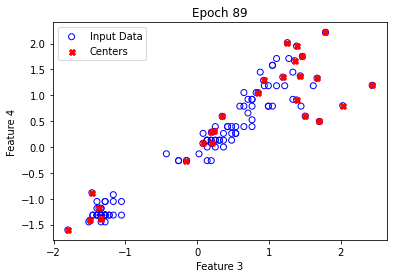

The amount of error in Epoch 90 is: 0.21271594289013804
The Number of New Centers in Epoch 90 is: 0
The Number of going through Gradient Descent in Epoch 90 is: 120
The number of centers in Epoch 90 is: 26
The Centers in Epoch 90 are as follows: 
[array([-1.08922039,  1.54858072, -1.80933681, -1.60646482]), array([ 1.78669032, -0.14462013,  0.34632041,  0.59313153]), array([ 0.20075518, -1.21223372,  0.07770837,  0.07062726]), array([1.58144645, 1.57619629, 1.78890668, 2.22447083]), array([ 2.52602715, -1.15027079,  2.44053115,  1.19807378]), array([-1.2405063 ,  0.08628368, -1.5013013 , -1.41696926]), array([-0.56616226, -1.980592  ,  1.35850802,  1.67214787]), array([-0.27340027,  0.11180646,  0.92460079,  1.29146517]), array([-0.05671694,  1.17878643,  1.38563633,  1.95724792]), array([ 0.6881818 , -1.05511584,  1.43672487,  1.38134066]), array([-0.20426816, -0.59808073,  1.25883456,  2.0235368 ]), array([-0.83481817,  1.08131631, -1.47635519, -0.88949081]), array([1.2311182 , 0.246

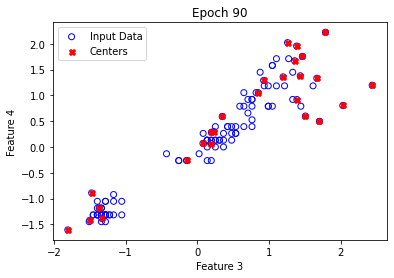

The amount of error in Epoch 91 is: 0.2132958529431747
The Number of New Centers in Epoch 91 is: 0
The Number of going through Gradient Descent in Epoch 91 is: 120
The number of centers in Epoch 91 is: 26
The Centers in Epoch 91 are as follows: 
[array([-1.08889013,  1.55581351, -1.81540379, -1.61097798]), array([ 1.78875907, -0.14428544,  0.34696344,  0.59072405]), array([ 0.20276005, -1.20619889,  0.07764835,  0.06980215]), array([1.58076759, 1.57682502, 1.7923874 , 2.22899735]), array([ 2.52613216, -1.15360734,  2.44561423,  1.20149307]), array([-1.23821618,  0.08639757, -1.50778324, -1.42224835]), array([-0.56599404, -1.98327402,  1.36232833,  1.67393024]), array([-0.27324512,  0.11081175,  0.92642522,  1.29432256]), array([-0.05764893,  1.18038957,  1.38901658,  1.96162743]), array([ 0.6882652 , -1.05774516,  1.44005001,  1.38525459]), array([-0.20442165, -0.5993003 ,  1.26299672,  2.02752097]), array([-0.8336077 ,  1.08590368, -1.48444596, -0.89642322]), array([1.23057003, 0.2443

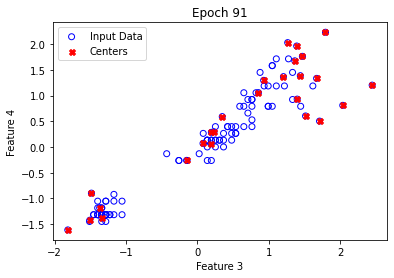

The amount of error in Epoch 92 is: 0.21387876278818688
The Number of New Centers in Epoch 92 is: 0
The Number of going through Gradient Descent in Epoch 92 is: 120
The number of centers in Epoch 92 is: 26
The Centers in Epoch 92 are as follows: 
[array([-1.08862299,  1.56300623, -1.82148838, -1.61547559]), array([ 1.79069306, -0.1439498 ,  0.34767137,  0.58821459]), array([ 0.20470365, -1.20021059,  0.07761009,  0.06888068]), array([1.58016558, 1.57739939, 1.7957763 , 2.23347096]), array([ 2.52629505, -1.15684377,  2.45058883,  1.20494299]), array([-1.23603603,  0.08664653, -1.51440172, -1.4276651 ]), array([-0.5658444 , -1.98597369,  1.36611343,  1.67575772]), array([-0.27308437,  0.10982399,  0.92822567,  1.29715778]), array([-0.05850832,  1.18197381,  1.39234125,  1.96599104]), array([ 0.68838846, -1.06035934,  1.44336866,  1.38920767]), array([-0.20453322, -0.60051   ,  1.26711477,  2.03152808]), array([-0.8324997 ,  1.09057409, -1.49262857, -0.90344981]), array([1.23009906, 0.242

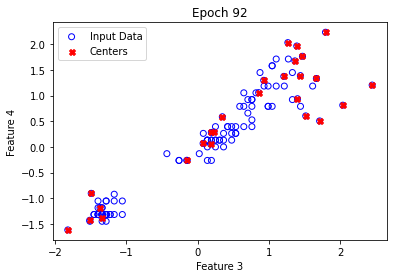

The amount of error in Epoch 93 is: 0.21446240077686773
The Number of New Centers in Epoch 93 is: 0
The Number of going through Gradient Descent in Epoch 93 is: 120
The number of centers in Epoch 93 is: 26
The Centers in Epoch 93 are as follows: 
[array([-1.08841897,  1.57016097, -1.82758607, -1.61995405]), array([ 1.79250087, -0.14361625,  0.34844455,  0.58560553]), array([ 0.20658886, -1.19427177,  0.07759067,  0.06786191]), array([1.57963357, 1.57792378, 1.7990732 , 2.23789342]), array([ 2.52651055, -1.15998663,  2.45545796,  1.20842125]), array([-1.23396844,  0.08702998, -1.52115452, -1.43321754]), array([-0.56571472, -1.98868922,  1.36986433,  1.67762958]), array([-0.27291832,  0.10884407,  0.93000204,  1.29996949]), array([-0.05930127,  1.18353884,  1.39560956,  1.97033752]), array([ 0.68854929, -1.06295684,  1.44667962,  1.39319825]), array([-0.20460692, -0.6017095 ,  1.27118839,  2.03555604]), array([-0.83149241,  1.09532893, -1.50089713, -0.91056427]), array([1.22970061, 0.240

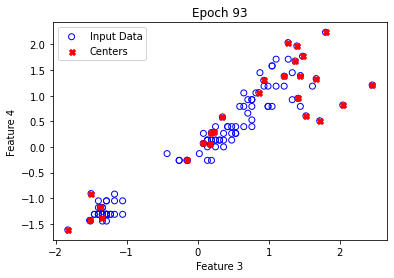

The amount of error in Epoch 94 is: 0.21504534487057728
The Number of New Centers in Epoch 94 is: 0
The Number of going through Gradient Descent in Epoch 94 is: 120
The number of centers in Epoch 94 is: 26
The Centers in Epoch 94 are as follows: 
[array([-1.08827782,  1.57727951, -1.83369231, -1.62440997]), array([ 1.79418988, -0.1432873 ,  0.34928244,  0.58289961]), array([ 0.20841791, -1.1883851 ,  0.077587  ,  0.0667453 ]), array([1.57916544, 1.57840201, 1.80227818, 2.24226598]), array([ 2.52677377, -1.16304184,  2.46022438,  1.21192534]), array([-1.23201577,  0.087547  , -1.52803907, -1.43890334]), array([-0.56560585, -1.99141877,  1.37358207,  1.67954486]), array([-0.27274728,  0.10787271,  0.93175428,  1.30275644]), array([-0.06003329,  1.18508434,  1.39882099,  1.97466554]), array([ 0.68874561, -1.06553639,  1.44998179,  1.39722454]), array([-0.2046462 , -0.60289855,  1.27521742,  2.03960262]), array([-0.83058394,  1.1001695 , -1.50924562, -0.91776014]), array([1.22937037, 0.238

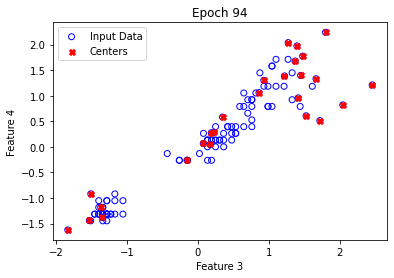

The amount of error in Epoch 95 is: 0.21562668383269223
The Number of New Centers in Epoch 95 is: 0
The Number of going through Gradient Descent in Epoch 95 is: 120
The number of centers in Epoch 95 is: 26
The Centers in Epoch 95 are as follows: 
[array([-1.08819923,  1.58436365, -1.83980285, -1.62884038]), array([ 1.79576602, -0.14296538,  0.35018364,  0.58009961]), array([ 0.2101923 , -1.18255311,  0.0775958 ,  0.06553057]), array([1.5787558 , 1.57883759, 1.8053916 , 2.24658969]), array([ 2.52708035, -1.16601493,  2.46489082,  1.21545266]), array([-1.23018029,  0.08819646, -1.53505265, -1.44471999]), array([-0.56551826, -1.99416058,  1.37726776,  1.68150252]), array([-0.27257151,  0.10691054,  0.93348246,  1.3055175 ]), array([-0.06070936,  1.18661007,  1.40197529,  1.97897379]), array([ 0.68897569, -1.06809684,  1.45327432,  1.40128478]), array([-0.2046541 , -0.60407696,  1.27920189,  2.04366569]), array([-0.82977241,  1.10509702, -1.51766805, -0.92503098]), array([1.22910443, 0.236

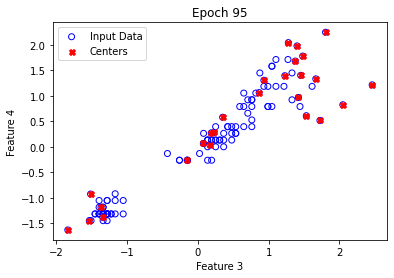

The amount of error in Epoch 96 is: 0.21620595896021474
The Number of New Centers in Epoch 96 is: 0
The Number of going through Gradient Descent in Epoch 96 is: 120
The number of centers in Epoch 96 is: 26
The Centers in Epoch 96 are as follows: 
[array([-1.08818274,  1.59141496, -1.84591352, -1.63324255]), array([ 1.79723466, -0.14265272,  0.35114645,  0.57720875]), array([ 0.21191327, -1.17677825,  0.07761395,  0.06421787]), array([1.5783999 , 1.57923378, 1.80841407, 2.25086532]), array([ 2.5274264 , -1.16891097,  2.46945989,  1.21900047]), array([-1.22846405,  0.08897705, -1.54219219, -1.45066464]), array([-0.56545212, -1.99691305,  1.38092249,  1.68350135]), array([-0.2723913 ,  0.10595811,  0.93518665,  1.3082516 ]), array([-0.06133398,  1.18811587,  1.40507241,  1.98326094]), array([ 0.68923797, -1.07063721,  1.4565564 ,  1.40537715]), array([-0.20463329, -0.60524465,  1.28314195,  2.04774308]), array([-0.82905585,  1.11011264, -1.52615838, -0.93237032]), array([1.2288992 , 0.234

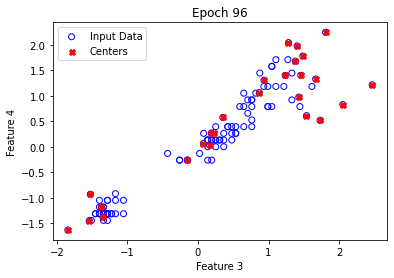

The amount of error in Epoch 97 is: 0.21678296644252829
The Number of New Centers in Epoch 97 is: 0
The Number of going through Gradient Descent in Epoch 97 is: 120
The number of centers in Epoch 97 is: 26
The Centers in Epoch 97 are as follows: 
[array([-1.08822783,  1.59843495, -1.85202038, -1.63761406]), array([ 1.79860073, -0.14235139,  0.35216904,  0.57423065]), array([ 0.21358189, -1.17106277,  0.07763854,  0.06280776]), array([1.57809362, 1.5795936 , 1.81134641, 2.25509346]), array([ 2.52780855, -1.1717347 ,  2.47393421,  1.22256598]), array([-1.22686883,  0.08988722, -1.54945433, -1.45673408]), array([-0.56540743, -1.9996747 ,  1.38454735,  1.68554007]), array([-0.27220696,  0.10501584,  0.93686692,  1.31095772]), array([-0.06191123,  1.18960169,  1.40811245,  1.9875257 ]), array([ 0.689531  , -1.07315669,  1.45982731,  1.40949979]), array([-0.20458614, -0.60640161,  1.28703784,  2.05183266]), array([-0.82843221,  1.11521746, -1.53471054, -0.93977171]), array([1.22875134, 0.232

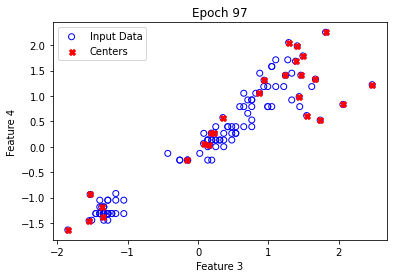

The amount of error in Epoch 98 is: 0.21774805362263122
The Number of New Centers in Epoch 98 is: 1
The Number of going through Gradient Descent in Epoch 98 is: 119
The number of centers in Epoch 98 is: 27
The Centers in Epoch 98 are as follows: 
[array([-1.08946275,  1.60471315, -1.85745668, -1.64201042]), array([ 1.80163407, -0.14574887,  0.3519457 ,  0.57123052]), array([ 0.21827232, -1.16660579,  0.07791434,  0.06266598]), array([1.5781461 , 1.58130521, 1.81482903, 2.25970154]), array([ 2.52896195, -1.17342421,  2.47983562,  1.22686349]), array([-1.22520634,  0.09044442, -1.55585605, -1.46237079]), array([-0.56710281, -2.00270286,  1.38863737,  1.68780062]), array([-0.27258902,  0.10455114,  0.93856264,  1.31367522]), array([-0.06277367,  1.19240402,  1.41158258,  1.99213541]), array([ 0.68930051, -1.07540396,  1.46417472,  1.41441633]), array([-0.20578873, -0.60671996,  1.29157566,  2.0566685 ]), array([-0.82825408,  1.11939863, -1.54268811, -0.9472737 ]), array([1.22924629, 0.232

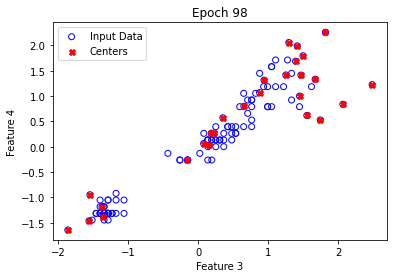

The amount of error in Epoch 99 is: 0.20742071891290068
The Number of New Centers in Epoch 99 is: 0
The Number of going through Gradient Descent in Epoch 99 is: 120
The number of centers in Epoch 99 is: 27
The Centers in Epoch 99 are as follows: 
[array([-1.09040364,  1.61107048, -1.86266564, -1.64614321]), array([ 1.80254954, -0.15173739,  0.35016265,  0.56721421]), array([ 0.22292048, -1.1627342 ,  0.0781195 ,  0.06283389]), array([1.57901067, 1.58385748, 1.81837876, 2.2642514 ]), array([ 2.53140168, -1.1736179 ,  2.48633861,  1.23151779]), array([-1.2234941 ,  0.09015703, -1.56197649, -1.46778173]), array([-0.56952124, -2.00585602,  1.39295343,  1.69022124]), array([-0.2729727 ,  0.10464874,  0.94019816,  1.31637065]), array([-0.06290529,  1.19647219,  1.41530596,  1.99704733]), array([ 0.68960618, -1.0768134 ,  1.46907592,  1.41971865]), array([-0.20704392, -0.6059335 ,  1.29642945,  2.06204292]), array([-0.82778161,  1.12342902, -1.55043213, -0.95438479]), array([1.23102843, 0.234

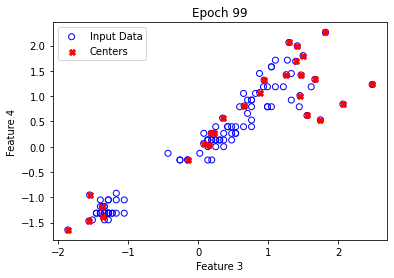

The amount of error in Epoch 100 is: 0.20719535129744496
The Number of New Centers in Epoch 100 is: 0
The Number of going through Gradient Descent in Epoch 100 is: 120
The number of centers in Epoch 100 is: 27
The Centers in Epoch 100 are as follows: 
[array([-1.09196515,  1.61720618, -1.86836035, -1.65062782]), array([ 1.80283203, -0.1574884 ,  0.34734569,  0.56227513]), array([ 0.22830081, -1.15778126,  0.07830107,  0.06304044]), array([1.58057855, 1.58687297, 1.82234352, 2.26929002]), array([ 2.53463435, -1.1735287 ,  2.49339836,  1.236663  ]), array([-1.22204781,  0.08947622, -1.56820059, -1.47331344]), array([-0.57254263, -2.00968974,  1.3974404 ,  1.69281998]), array([-0.27348684,  0.10488485,  0.94183983,  1.31915108]), array([-0.06278567,  1.20112615,  1.41943603,  2.00259621]), array([ 0.69019285, -1.07838015,  1.47452367,  1.42552237]), array([-0.20852937, -0.60514275,  1.30165979,  2.06805604]), array([-0.82758504,  1.12750417, -1.55849663, -0.96175215]), array([1.2338159 , 

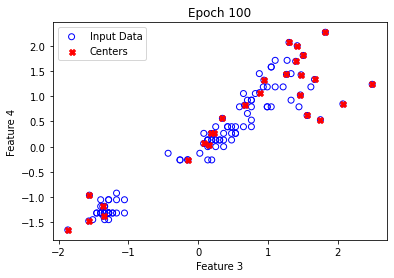

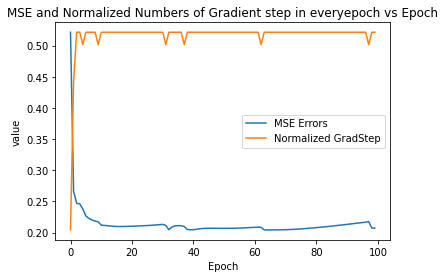

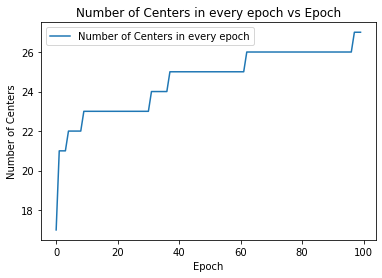

The Number of going through Gradient Descent in all epochs are: 
[104, 116, 120, 120, 119, 120, 120, 120, 120, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 119, 120, 120, 120, 120, 120, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 119, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 120, 119, 120, 120]
The Number of New Centers in all epochs are: 
[16, 4, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]
The number of centers are: 27
The Centers at the end of algorithm are as follows: 
[ar

In [27]:
#According to the article delta_max is the largest length of the entire input space of non_zero probability density
delta_max = np.max(np.linalg.norm(X_train, axis=1))
#Create an object of ResourceAllocatingNetwork.
ran = ResourceAllocatingNetwork(input_size, output_size)
#Epsilon is a desired accuracy of output of the Network.
#epsilon = 0.02
epsilon = 0.5
# The distance delta shrinks until it raches delta_min which is a smallest length.
# the network will average over features that are smaller than delta_min.
#delta_min = 0.07
delta_min = 0.9
# k is an overlap factor. As k grows larger, the responses of the units overlap more nd more.
#k = 0.87
k = 0.5
# tau is a decay constant
#tau = 17
tau = 30
# alpha is learning rate
#alpha = 0.02
alpha = float(input("Enter the learning rate (alpha): "))
num_epochs = 100
#error_threshold = 0.2
error_threshold = float(input("Enter the Error Threshold (error_threshold): "))
ran.train(X_train, y_train_encoded, epsilon, delta_max, delta_min, k, tau, alpha, num_epochs, error_threshold)

In [28]:
# Predict Y values of X_test
y_pred = ran.predict(X_test)

# Evaluate accuracy of Ys that were predicted
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0
